# PCA Analysis 

This notebook provides a demonstration of PCA on condensate images.

Allard Mosk, a.p.mosk@uu.nl, May 2025

In [7]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb
import scipy
import matplotlib.cm as cm
import matplotlib.mathtext as mathtext
import scipy.signal
from scipy import signal
import mpmath
#from astropy.io import fits
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from skimage.restoration import unwrap_phase

import time

from io import BytesIO

from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from matplotlib.transforms import IdentityTransform
import matplotlib.cm as cm

from PIL import Image
import requests

rng=np.random.default_rng() #random number generator

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%matplotlib notebook
# plt.style.use('fivethirtyeight')  # pretty cool looking 
import warnings
warnings.filterwarnings('ignore')
from decimal import Decimal

import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.widgets import Slider
from matplotlib import colors
from matplotlib.gridspec import GridSpec
from IPython.display import clear_output
import scipy.odr as odr
import imageio
import gc
from matplotlib.widgets import EllipseSelector, RectangleSelector
from matplotlib.pyplot import cm
from scipy.special import eval_legendre
from scipy.optimize import curve_fit
import scipy.fftpack as fft
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Arc
import csv
from scipy.ndimage import center_of_mass

from OAH_refocus import *
import time
import sys
import argparse
import glob
import csv
import matplotlib
import math
from scipy.optimize import curve_fit
from fitfunctions import gaussmod, tfmod, bimodalmod, tfaxialmod, gaussmod_OAH, tfmod_OAH, bimodalmod_OAH
from scipy.ndimage.interpolation import rotate
from scipy.special import zeta
from scipy.signal import savgol_filter
import os
import cv2
from PIL import Image

# Import own fit functions
import OAH_functions as f1
# import OAHDEV_functions as f2
from OAHDEV_functions import *
# from ..data_analysis import fits_analysis as fa

# Constants:
kB = 1.38064852E-23
m = 3.81923979E-26
hb = 1.0545718E-34
asc = 2.802642E-9
mu0 = 1E-50
e0 = 8.854187E-12
pix_size = 6.5E-6 / 2.63
# Light field properties
lamb0 = 589.1E-9  # Wavelength
k0 = 2 * np.pi / lamb0  # k-vector

save_folder = '/home/bec_lab/Desktop/imgs/SOAH/SpinAnalysisApril2025/PCA/'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [8]:
# cropping parameters for the loaded images.
cropBottom=-9
cropTop=10
cropLeft=100
cropRight=-100

#pChebyshev polynomial orders for the background gradient correction.
gradientremovalorder_X=7
gradientremovalorder_Y=3

number_of_images=50 # use only a subset to speed up and reduce memory usage

In [9]:
# load the images from SurfDrive or local disk
# Get images - flat, atoms, 
folder = '/home/bec_lab/Desktop/imgs/SOAH/PCA_Analysis/data/OAH_processing/'

file_blank = f'full_complex_field_20250507_66_flat.npy'
fileAtoms = f'full_complex_field_20250507_66_atoms.npy'
# file_OldNormalized='/home/bec_lab/Desktop/imgs/SOAH/PCA_Analysis/data/OAH_processing/full_complex_field_20250507_66.npy'


# Load from local disk
# oldNormalized=np.load(file_OldNormalized, allow_pickle=True)
full_blank_images=np.load(folder + file_blank, allow_pickle=True)
full_complex_images_Atoms=np.load(folder + fileAtoms)
#end if

# Crop the images to the region of interest
blank_images=full_blank_images[:number_of_images,:,cropTop:cropBottom,cropLeft:cropRight]
complex_images_Atoms=full_complex_images_Atoms[:number_of_images,:,cropTop:cropBottom,cropLeft:cropRight]
(nimages,dummy,xdim,ydim)=blank_images.shape

In [10]:
#A function to nicely plot complex images, coding amplitude to brightness and phase to color
def Complex2HSV(z, rmin, rmax, hue_start=90,dphi=360):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    ph = np.angle(z, deg=1)
    # HSV are values in range [0,1]
    h = (ph / dphi + hue_start/360)%1
    s = 0.85 * np.ones_like(h)
    v = (amp -rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

In [11]:
def RemovePhaseGradient(image):
    # Remove phase gradients from an image by Chebyshev fit to the unwrapped phase.
    (xdim_,ydim_)=image.shape
    image_unwrapped = unwrap_phase(np.angle(image))


    # Create a grid of points
    X_axis =np.linspace(-1,1,xdim_)
    Y_axis =np.linspace(-1,1,ydim_)
    X_,Y_ = np.meshgrid(X_axis,Y_axis)
    X=X_.flatten()
    Y=Y_.flatten()

    flat1=np.mean(image_unwrapped,axis=0)
    flat2=np.mean(image_unwrapped,axis=1)
    fit1=np.polynomial.chebyshev.chebfit(Y_axis, flat1, gradientremovalorder_Y)
    fit2=np.polynomial.chebyshev.chebfit(X_axis, flat2, gradientremovalorder_X)
    fit2[0]=0
    fiteval=np.polynomial.chebyshev.chebval(Y_axis, fit1)+np.outer(np.ones_like(Y_axis),np.polynomial.chebyshev.chebval(X_axis, fit2)).T

    return np.exp(-1.0j*fiteval)*image



In [12]:
# remove phase gradients from all images and convert to phase only
show_images=False
gradient_removeds_blank=np.zeros_like(blank_images, dtype=float)
gradient_removeds_Atoms=np.zeros_like(complex_images_Atoms,dtype=float)
# Determine how many images you want to plot and the layout of the grid
num_images_to_plot = number_of_images  # Example: Plot the first 4 images
n_cols = 2              # Number of columns in the subplot grid
n_rows = num_images_to_plot   # Calculate number of rows needed


# Loop through the selected images and plot them
for i in range(num_images_to_plot):
  # Create a figure and a grid
  if show_images:
    fig, axes = plt.subplots(1, n_cols, figsize=(16 * n_cols, 3)) # Adjust figsize dynamicallye dynamically
  #end if
  for j in range(n_cols):
    image_data = blank_images[i, j, :,:]
    image_data = RemovePhaseGradient(image_data)
    gradient_removeds_blank[i, j, :,:] = np.angle(image_data)
    cropped_image=image_data[:,1000:2000]

    # Plot the image on the current axes
    if show_images:
        axes[j].imshow(Complex2HSV(z=cropped_image, rmin=0, rmax=1))
        axes[j].set_title(f"Image {0 + i + 1}, {j}") # Add a title to each subplot
    #end if
  #end for
  plt.show()
  #repeat for the images with atoms
  if show_images:
    fig, axes = plt.subplots(1, n_cols, figsize=(16 * n_cols, 3)) # Adjust figsize dynamically
  #end if
  for j in range(n_cols):
    image_data = complex_images_Atoms[i, j, :,:]
    image_data = RemovePhaseGradient(image_data)
    gradient_removeds_Atoms[i, j, :,:] = np.angle(image_data)
    cropped_image=image_data[:,1000:2000]

    # Plot the image on the current axes
    if show_images:
        axes[j].imshow(Complex2HSV(z=cropped_image, rmin=0, rmax=1))
        axes[j].set_title(f"Atoms Image {0 + i + 1}, {j}") # Add a title to each subplot
    #end if
  #end for
  if show_images:
    plt.show()



In [13]:
noatom_data=gradient_removeds_blank.copy()
noatom_reconstruct=gradient_removeds_blank.copy()

# remove the area where the atoms could be
# this could possibly be done a bit tighter.
noatom_data[:,:,20:-20,1000:2000]=0


In [14]:
flatstack=noatom_data.reshape( (number_of_images,2,-1) )
flatstack_reconstruct=noatom_reconstruct.reshape( (number_of_images,2,-1) )
flatstack_Atoms=gradient_removeds_Atoms.reshape( (number_of_images,2,-1) )

In [15]:
stack0=flatstack[:,0,:]
stack0A=flatstack_Atoms[:,0,:]
stack0r=flatstack_reconstruct[:,0,:]
stack1=flatstack[:,1,:]
mysvd0=np.linalg.svd(stack0,full_matrices=False)
U, S, Vh = mysvd0
#mysvd1=np.linalg.svd(stack1)

In [16]:
#This is a modified version of the Vh matrix, which is used to reconstruct the background
# it fills in the missing values in the Vh matrix
VHY = (np.conj(U.T)@stack0r)
VHY = (S**-1)[:,np.newaxis]*VHY

In [17]:
# Lets estimate how much of the variance is explained by the first V singular values
# This is the ratio of the sum of the squares of the first V singular values to the sum of the squares of all singular values
V=12
f_explained=((S[1:V])**2).sum()/((S[1:])**2).sum()
print(f"Fraction of variance explained by the first {V} singular values: {f_explained:.2f}")
print(f"Estimated noise suppression factor: {1/(1-f_explained):.2f}")

Fraction of variance explained by the first 12 singular values: 0.78
Estimated noise suppression factor: 4.57


<IPython.core.display.Javascript object>


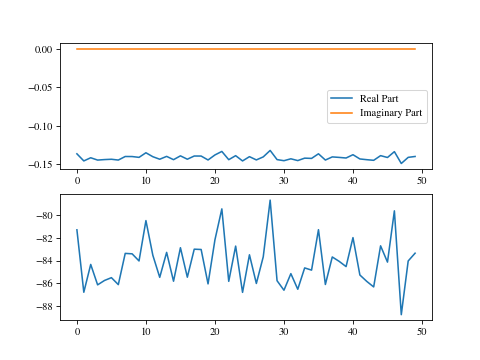

In [18]:
# plot the contribution of one of the singular vectors in time.
i=0 #which singular vector to plot
fig, ax = plt.subplots(2, 1)
ax[0].plot(np.real(U[:,i]), label='Real Part')
ax[0].plot(np.imag(U[:,i]), label='Imaginary Part')
ax[1].plot(np.real(Vh[i].conjugate()@stack0.T), label='Real Part')
ax[0].legend()
plt.show()


<IPython.core.display.Javascript object>


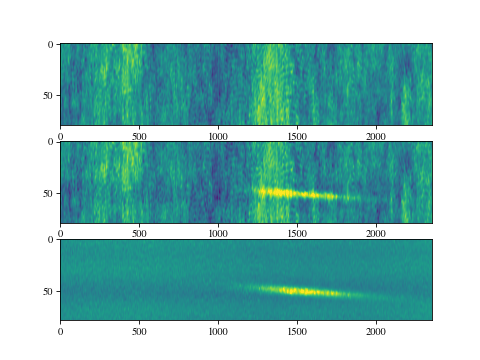

<IPython.core.display.Javascript object>


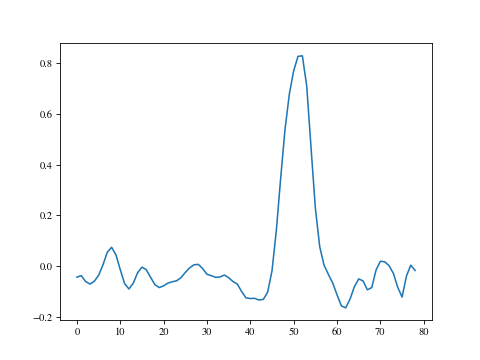

In [59]:
# Now we clean the images with atoms
# we now try to predict one of our atom images
t=3
V=6 # number of singular values to use
phaserange=1.0
coeff=(Vh.T.conjugate()).T@stack0A[t]
sim=coeff[:V] @ VHY[:V,:]
sim=sim.reshape(xdim,ydim)

fig, ax = plt.subplots(3, 1)
ax[0].imshow(sim, vmin=-phaserange, vmax=phaserange, aspect='auto')
ax[1].imshow(gradient_removeds_Atoms[t,0], vmin=-phaserange, vmax=phaserange, aspect='auto')
ax[2].imshow(gradient_removeds_Atoms[t,0]-sim, vmin=-phaserange, vmax=phaserange, aspect='auto')
plt.show()

fig, ax = plt.subplots(1, 1)
ax.plot((gradient_removeds_Atoms[t,0]-sim)[:,1500])
# ax.plot(np.angle(oldNormalized*np.exp(np.pi*1.0j))[t,0,5:,1500]+0.1)
plt.show()


<IPython.core.display.Javascript object>


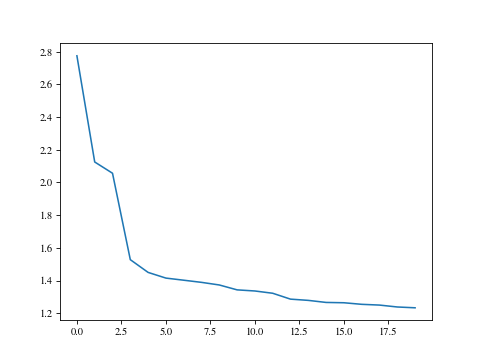

In [87]:
plt.figure()
plt.plot(np.log10(S[0:20]))
plt.show()

In [36]:
date = '20250507'
run = '0066' 
num=0


input_folder = '/storage/data/' + date + '/' + run + "/"
atom = pyfits.open(input_folder + '0.fits')[0].data.astype(float)[num]  # .mean(axis=0)
flat = pyfits.open(input_folder + '1.fits')[0].data.astype(float)[0]  # .mean(axis=0)
dark = pyfits.open(input_folder + '2.fits')[0].data.astype(float).mean(axis=0)

# --------------------------------------- CREATE THE PICTURE ARRAY ------------------------------------------
atom_corr = atom - dark
flat_corr = flat - dark 
# atom_corr[atom_corr < 0.0001] = 0.0001
# flat_corr[flat_corr < 0.0001] = 0.0001

pic_atom = atom_corr#  / flat_corr
pic_atom[pic_atom < 0.0001] = 0.0001
# mask = flat - dark < 25.
pic_atom = np.ma.array(pic_atom, mask=mask)

pic_flat = flat_corr
pic_flat[pic_flat < 0.0001] = 0.0001
# mask = flat - dark < 25.
pic_flat = np.ma.array(pic_flat, mask=mask)


<IPython.core.display.Javascript object>


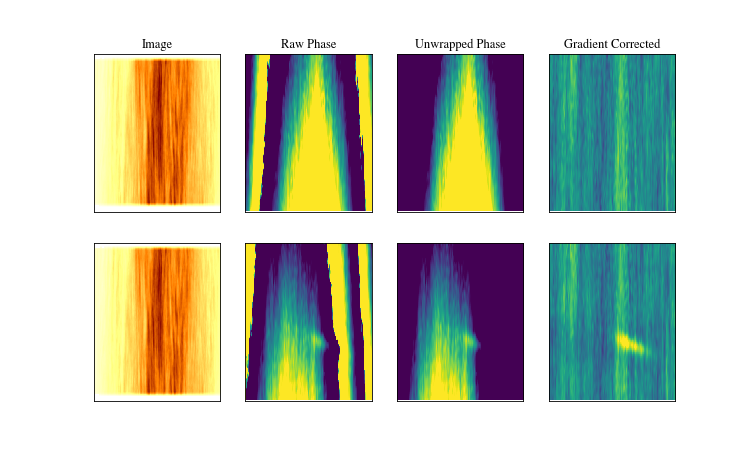

In [50]:
fig, ax = plt.subplots(2, 4, figsize=(10, 6))


ax[0][0].set_ylabel("FLAT")
ax[0][0].set_ylabel("ATOMS")

ax[0][0].imshow(pic_flat, aspect='auto', cmap='afmhot_r')
ax[1][0].imshow(pic_atom, aspect='auto', cmap='afmhot_r')
ax[0][0].set_title("Image")


ax[0][1].imshow(np.angle(blank_images[0,0]), vmin=-phaserange, vmax=phaserange, aspect='auto')
ax[1][1].imshow(np.angle(complex_images_Atoms[0,0]), vmin=-phaserange, vmax=phaserange, aspect='auto')
ax[0][1].set_title("Raw Phase")

ax[0][2].imshow(unwrap_phase(np.angle(blank_images[0,0])), vmin=-phaserange, vmax=phaserange, aspect='auto')
ax[1][2].imshow(unwrap_phase(np.angle(complex_images_Atoms[0,0])), vmin=-phaserange, vmax=phaserange, aspect='auto')
ax[0][2].set_title("Unwrapped Phase")

ax[0][3].imshow(unwrap_phase(np.angle(RemovePhaseGradient(blank_images[0,0]))), vmin=-phaserange, vmax=phaserange, aspect='auto')
ax[1][3].imshow(unwrap_phase(np.angle(RemovePhaseGradient(complex_images_Atoms[0,0]))), vmin=-phaserange, vmax=phaserange, aspect='auto')
ax[0][3].set_title("Gradient Corrected")

for ax in fig.axes:
    ax.set_yticks([])
    ax.set_xticks([])




plt.show()

<IPython.core.display.Javascript object>


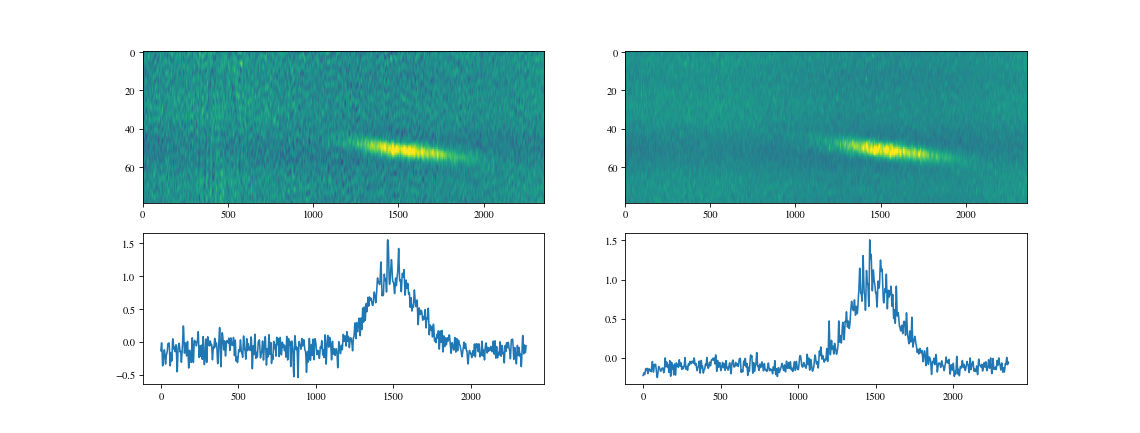

In [57]:
fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(unwrap_phase(np.angle(RemovePhaseGradient(complex_images_Atoms[0,0]))) - unwrap_phase(np.angle(RemovePhaseGradient(blank_images[0,0]))), vmin=-phaserange, vmax=phaserange, aspect='auto')
ax[0][1].imshow(unwrap_phase(np.angle(RemovePhaseGradient(complex_images_Atoms[0,0]))) - sim, vmin=-phaserange, vmax=phaserange, aspect='auto')


ax[1][0].plot((unwrap_phase(np.angle(RemovePhaseGradient(complex_images_Atoms[0,0]))) - unwrap_phase(np.angle(RemovePhaseGradient(blank_images[0,0]))))[50])
ax[1][1].plot((unwrap_phase(np.angle(RemovePhaseGradient(complex_images_Atoms[0,0]))) - sim)[50])

ax[1][0].plot((unwrap_phase(np.angle(RemovePhaseGradient(complex_images_Atoms[0,0]))) - unwrap_phase(np.angle(RemovePhaseGradient(blank_images[0,0]))))[50])
ax[1][1].plot((unwrap_phase(np.angle(RemovePhaseGradient(complex_images_Atoms[0,0]))) - sim)[50])

plt.show()

<IPython.core.display.Javascript object>


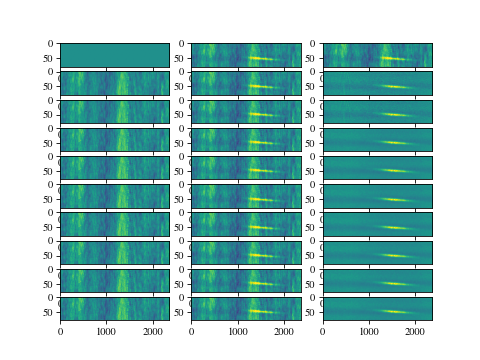

In [139]:
# Now we clean the images with atoms
# we now try to predict one of our atom images
t=0
fig, ax = plt.subplots(10, 3)

for V in range(0, 10):
#     V=6 # number of singular values to use
    phaserange=1.0
    coeff=(Vh.T.conjugate()).T@stack0A[t]
    sim=coeff[:V] @ VHY[:V,:]
    sim=sim.reshape(xdim,ydim)

    ax[V][0].imshow(sim, vmin=-phaserange, vmax=phaserange, aspect='auto')
    ax[V][1].imshow(gradient_removeds_Atoms[t,0], vmin=-phaserange, vmax=phaserange, aspect='auto')
    ax[V][2].imshow(gradient_removeds_Atoms[t,0]-sim, vmin=-phaserange, vmax=phaserange, aspect='auto')
plt.show()




<IPython.core.display.Javascript object>


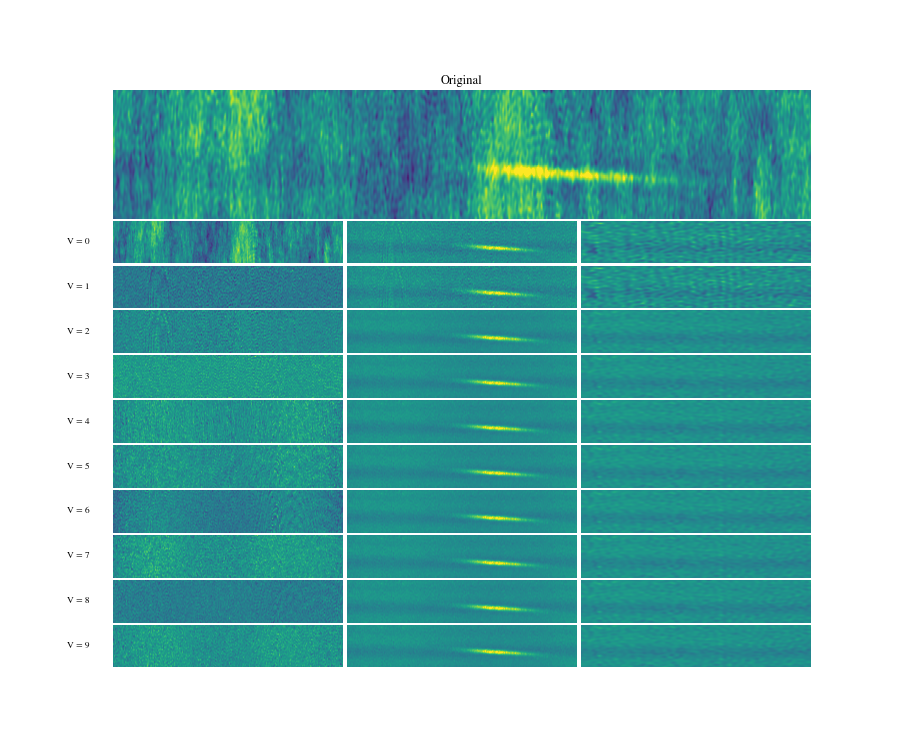

In [171]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

t = 0
phaserange = 1.0
tot = gradient_removeds_Atoms[t, 0].copy()

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(11, 3, figure=fig, hspace=0.04, wspace=0.02, height_ratios=[3, 1, 1, 1, 1, 1, 1, 1, 1,1, 1])

ax_original = fig.add_subplot(gs[0, :])
ax_original.imshow(gradient_removeds_Atoms[t, 0], vmin=-phaserange, vmax=phaserange, aspect='auto')
ax_original.axis('off')
ax_original.set_title("Original")
for V in range(10):
    coeff_V = np.dot(Vh[V].conj(), stack0A[t])
    component = coeff_V * VHY[V]
    sim = component.reshape(xdim, ydim)

    ax0 = fig.add_subplot(gs[V+1, 0])
    ax0.imshow(sim, aspect='auto')
    ax0.axis('off')
    ax0.text(-0.1, 0.5, f"V = {V}", transform=ax0.transAxes,
         va='center', ha='right', rotation=0, fontsize=9)

    tot -= sim
    ax3 = fig.add_subplot(gs[V+1, 1])
    ax3.imshow(tot, vmin=-phaserange, vmax=phaserange, aspect='auto')
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[V+1, 2])
    ax4.imshow(tot[:, 550:850], vmin=-phaserange, vmax=phaserange, aspect='auto')
    ax4.axis('off')
    
    
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


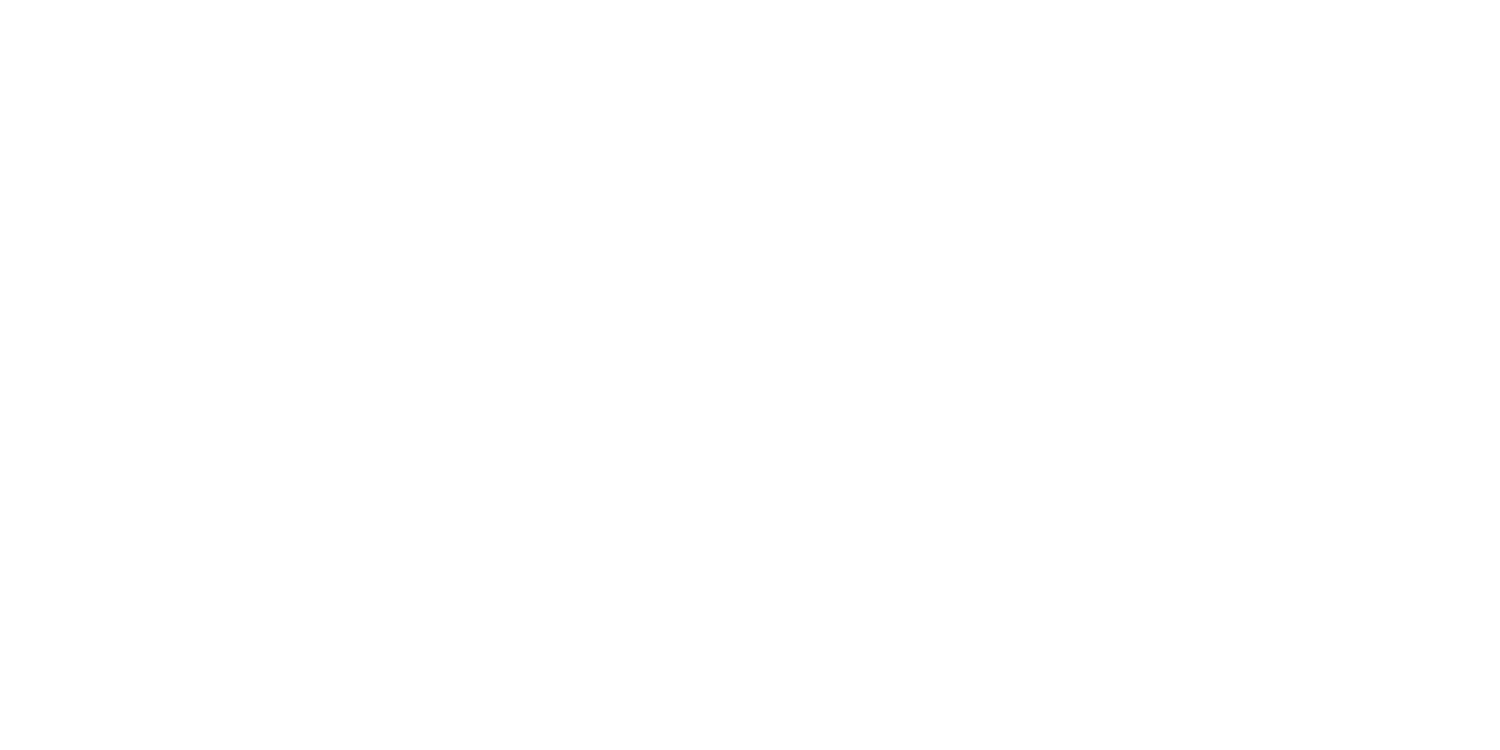

<IPython.core.display.Javascript object>


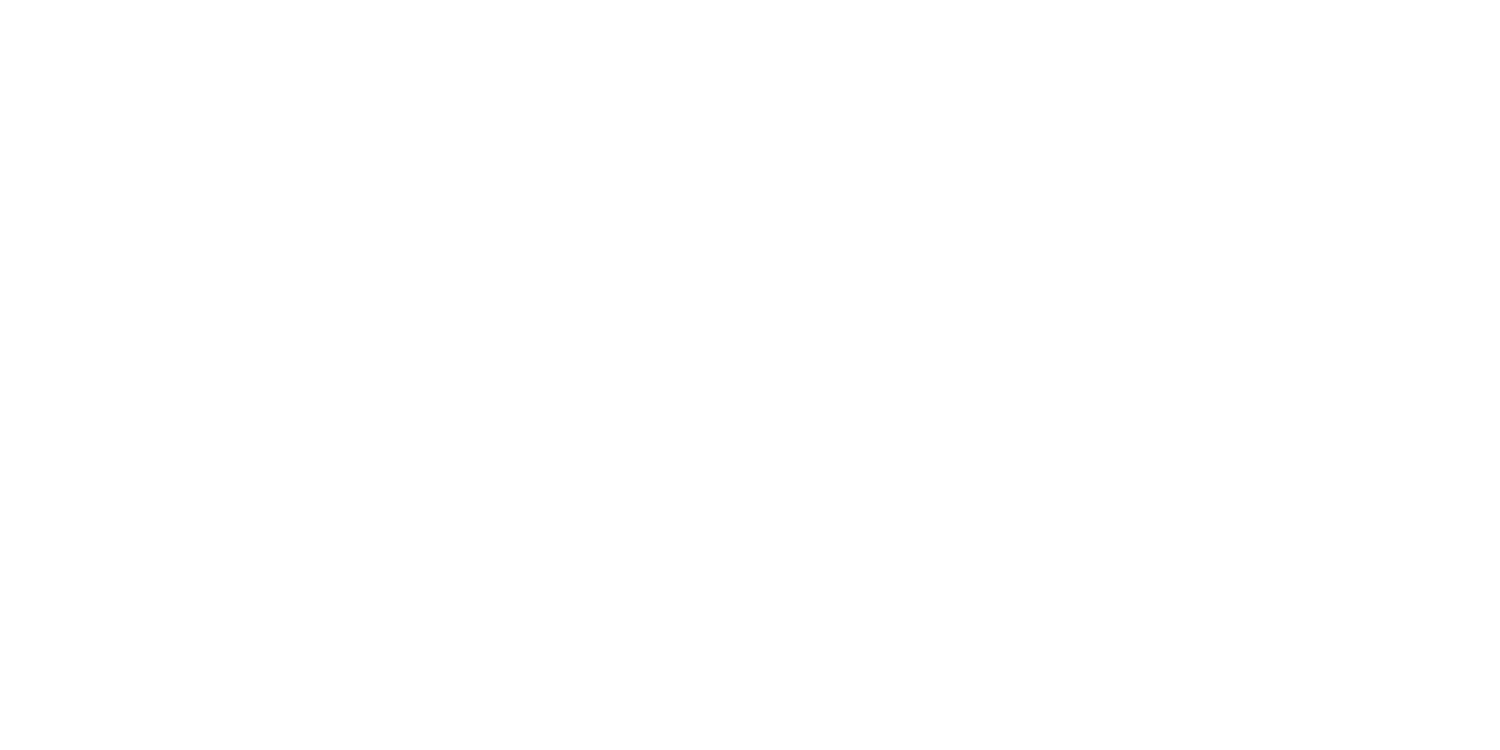

<IPython.core.display.Javascript object>


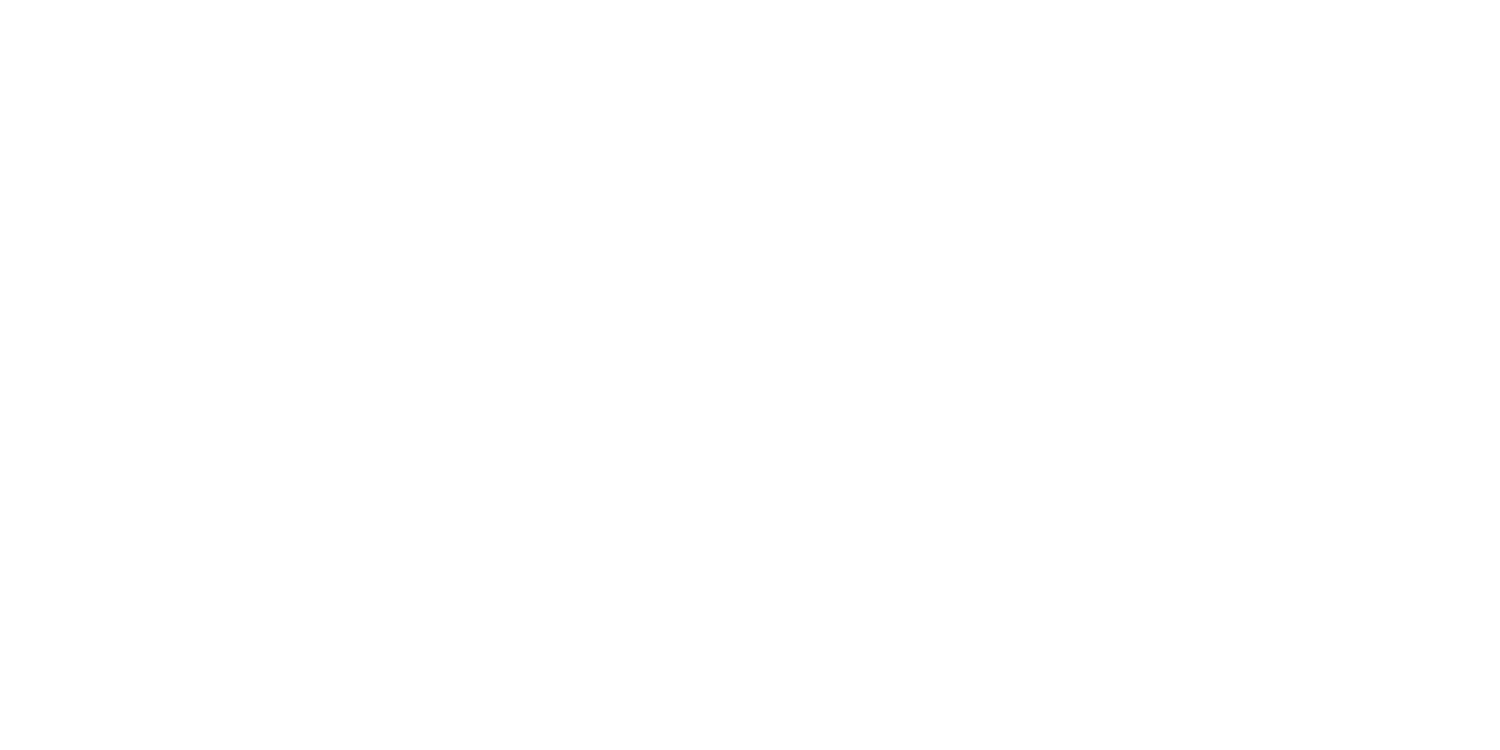

<IPython.core.display.Javascript object>


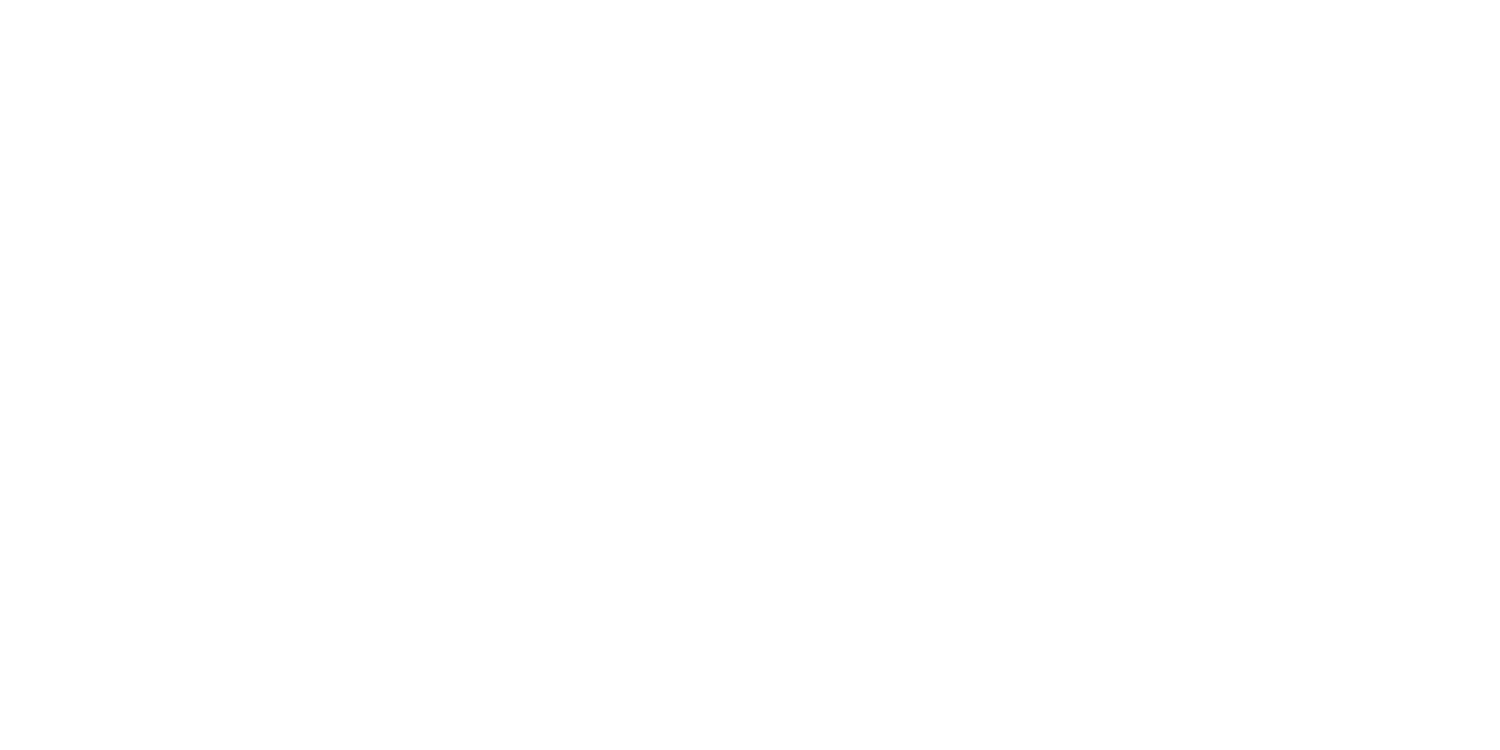

<IPython.core.display.Javascript object>


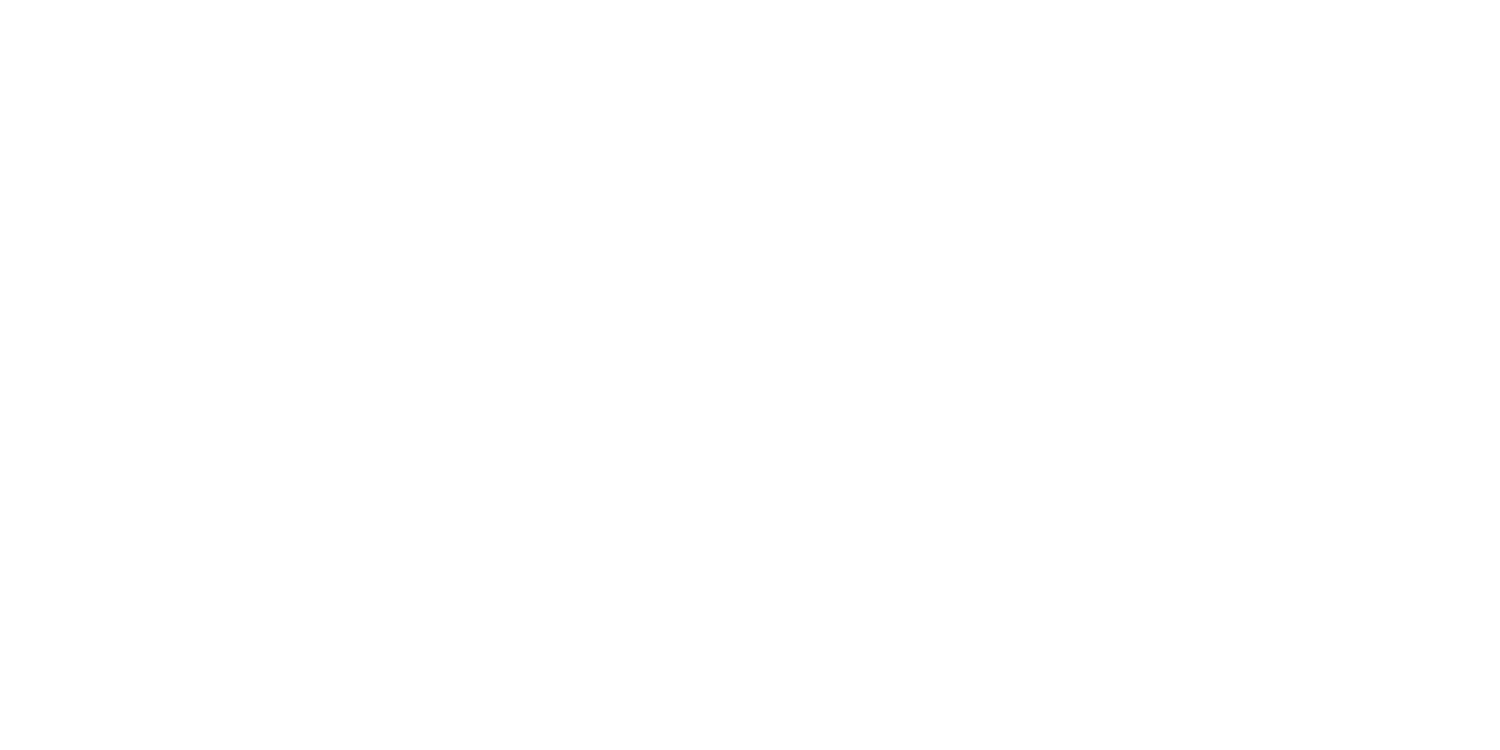

<IPython.core.display.Javascript object>


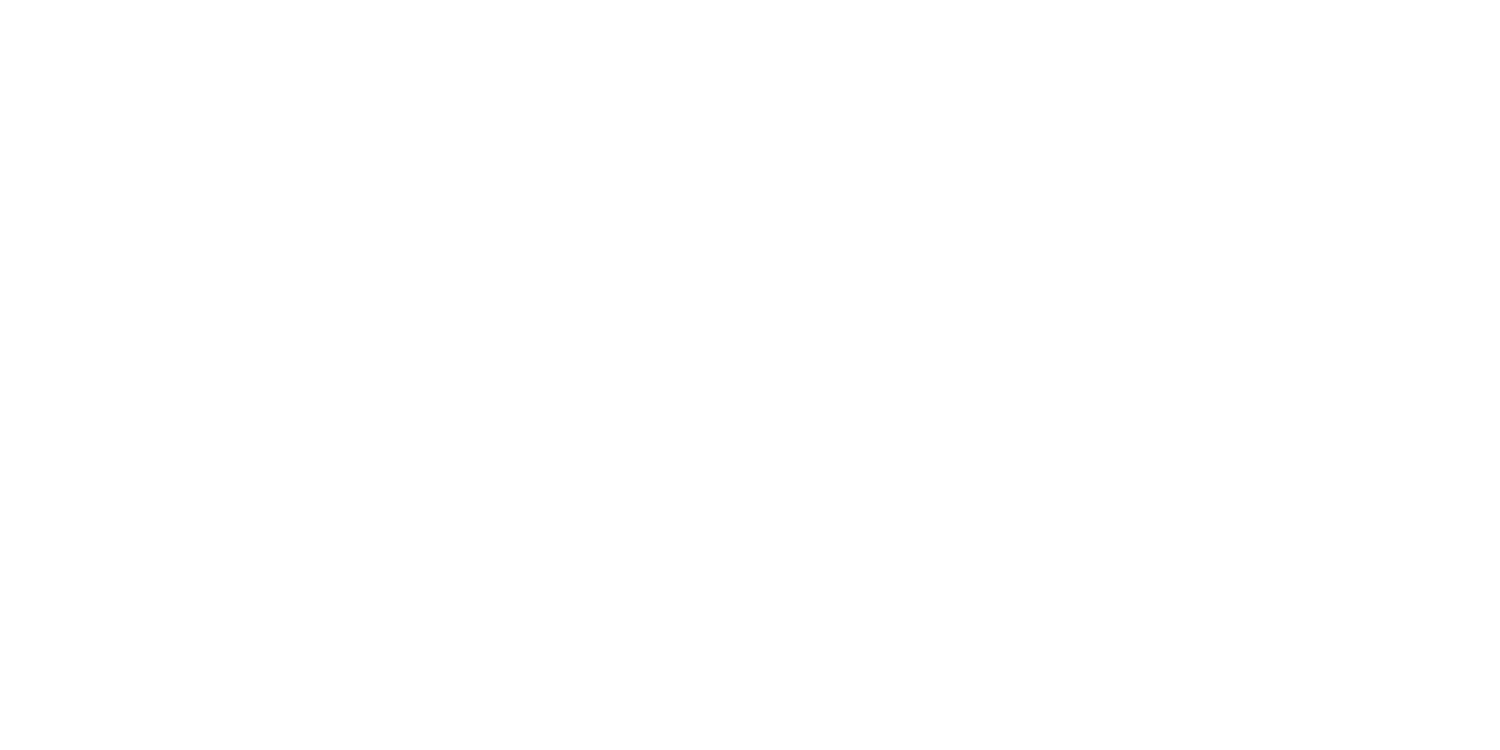

<IPython.core.display.Javascript object>


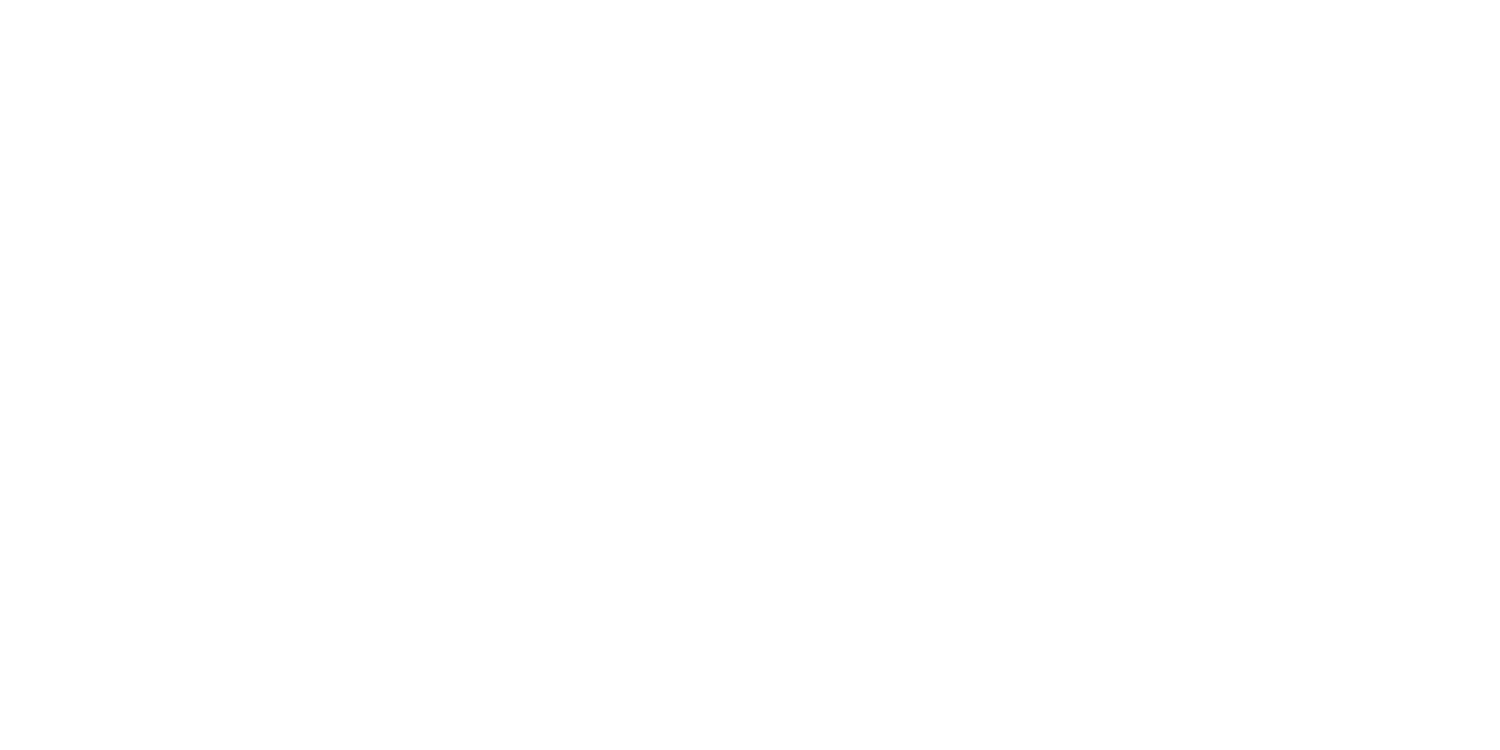

<IPython.core.display.Javascript object>


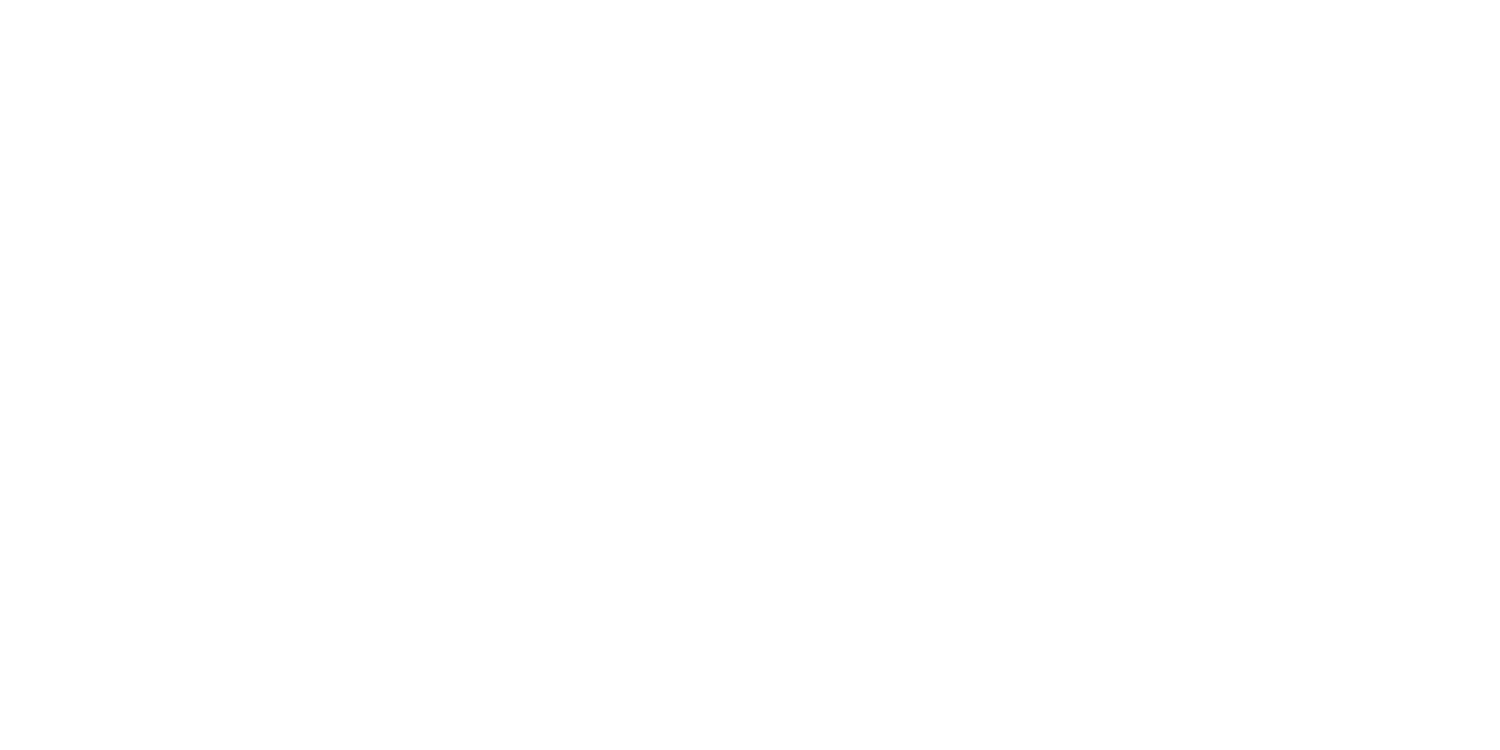

<IPython.core.display.Javascript object>


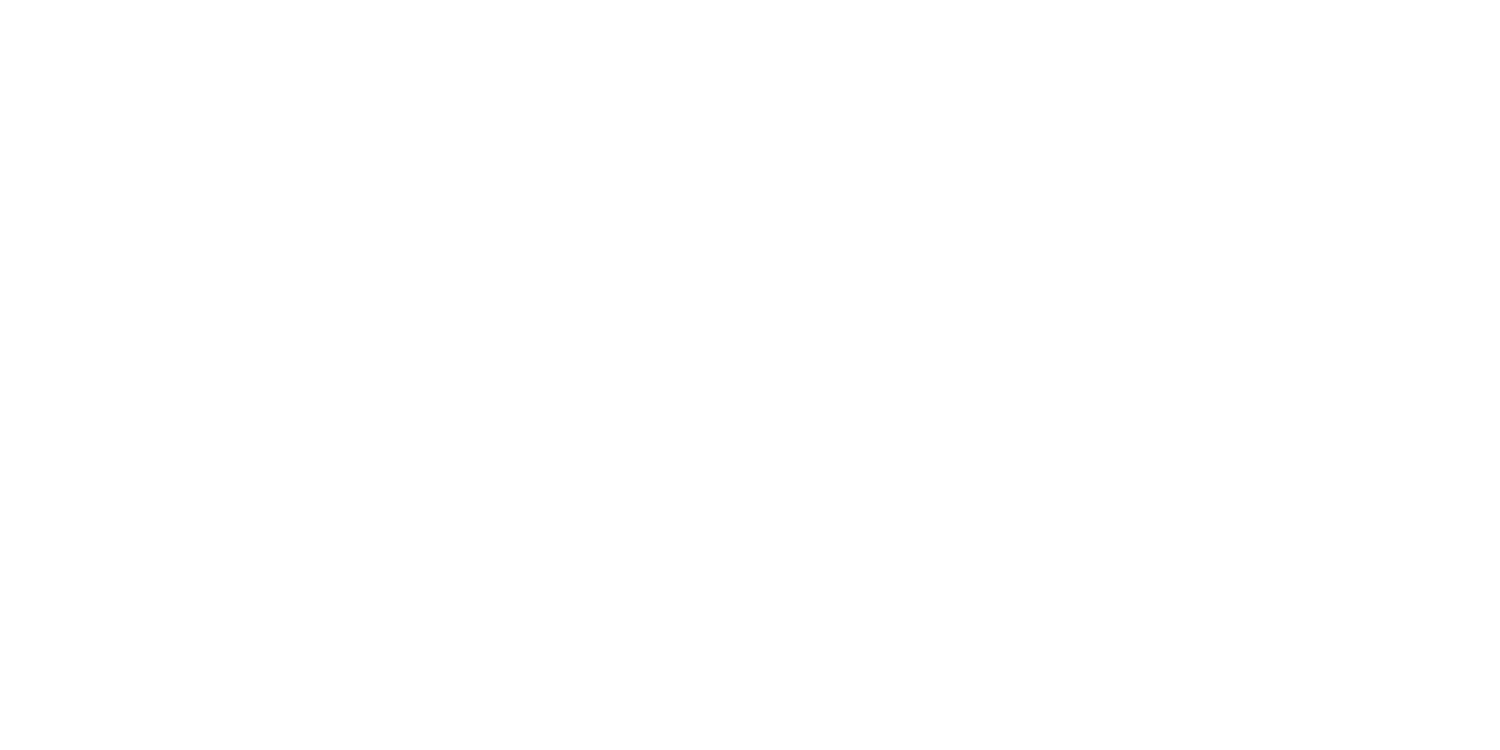

<IPython.core.display.Javascript object>


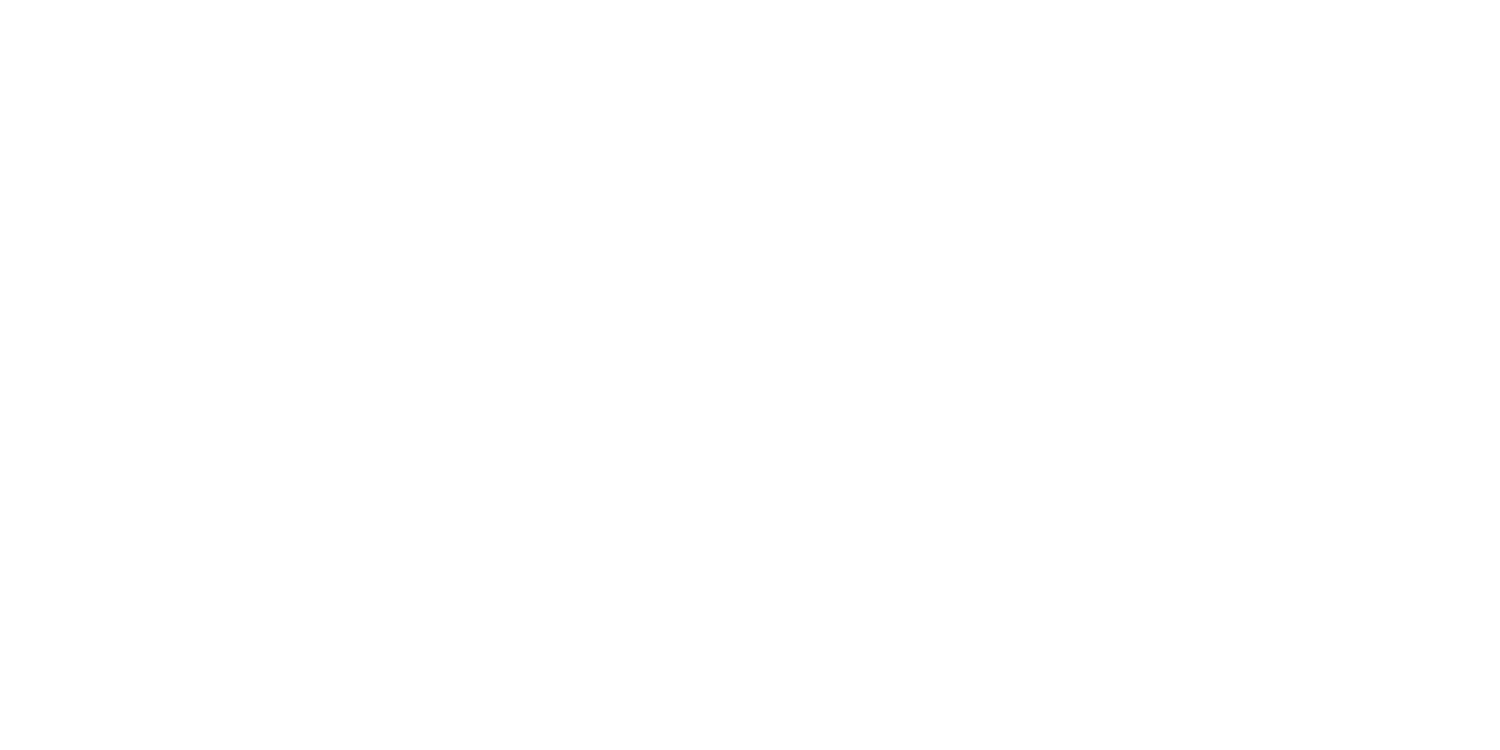

<IPython.core.display.Javascript object>


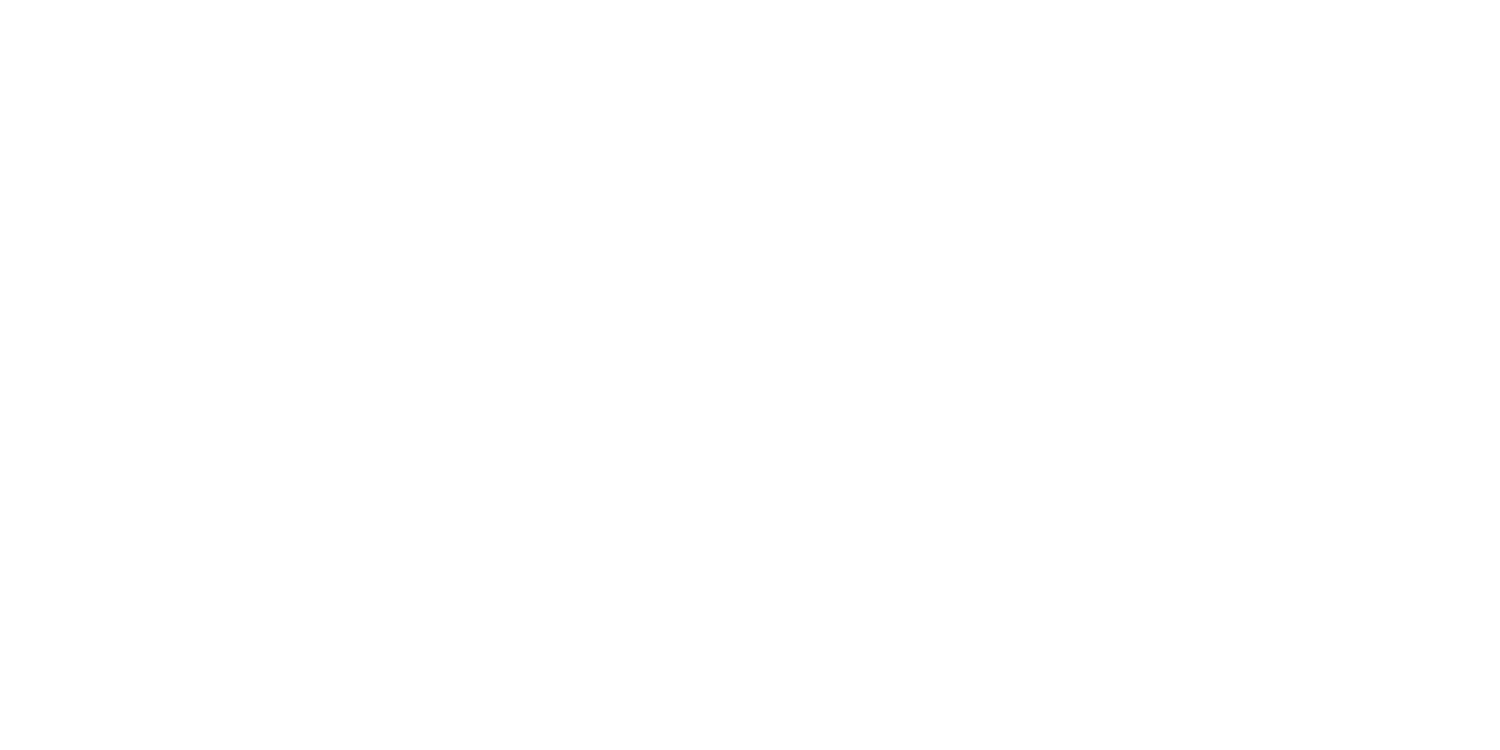

<IPython.core.display.Javascript object>


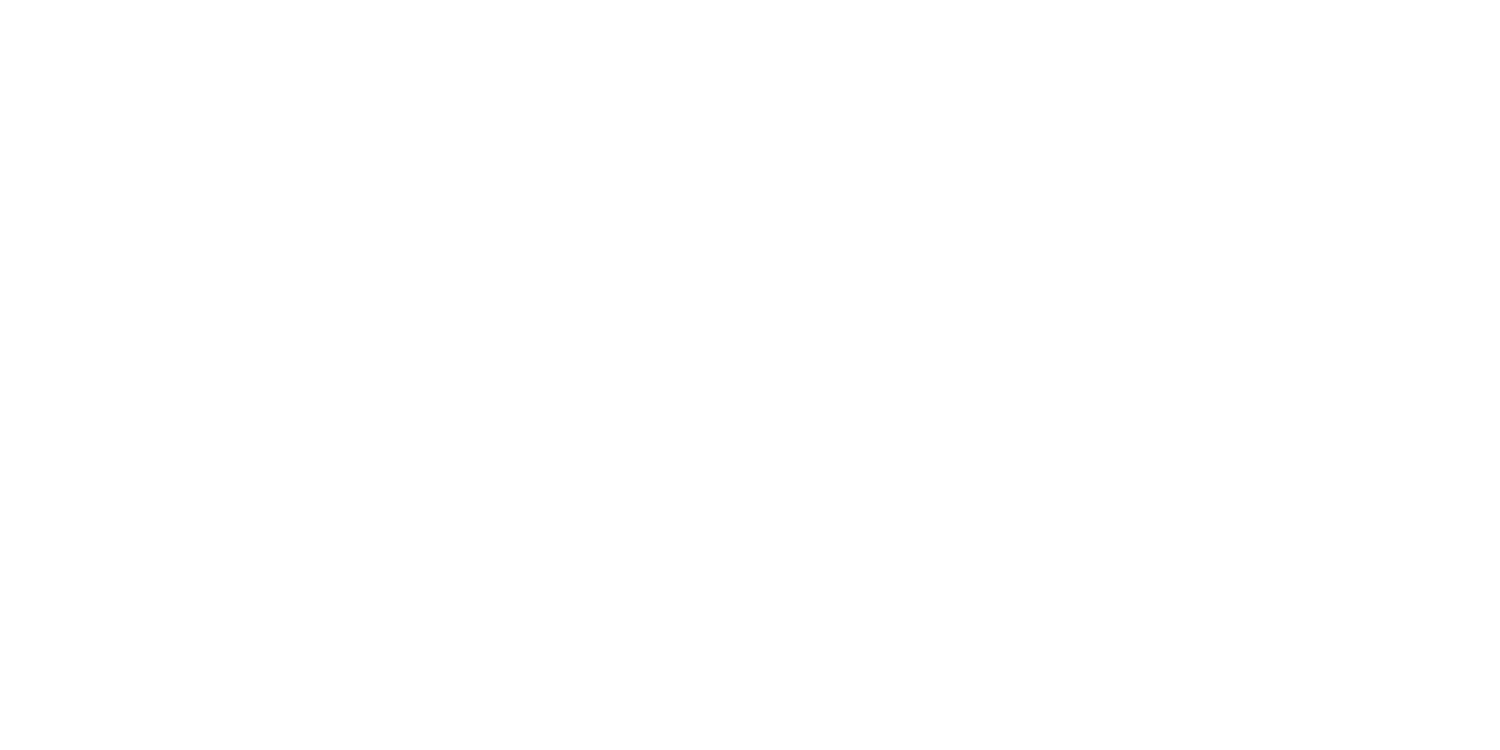

<IPython.core.display.Javascript object>


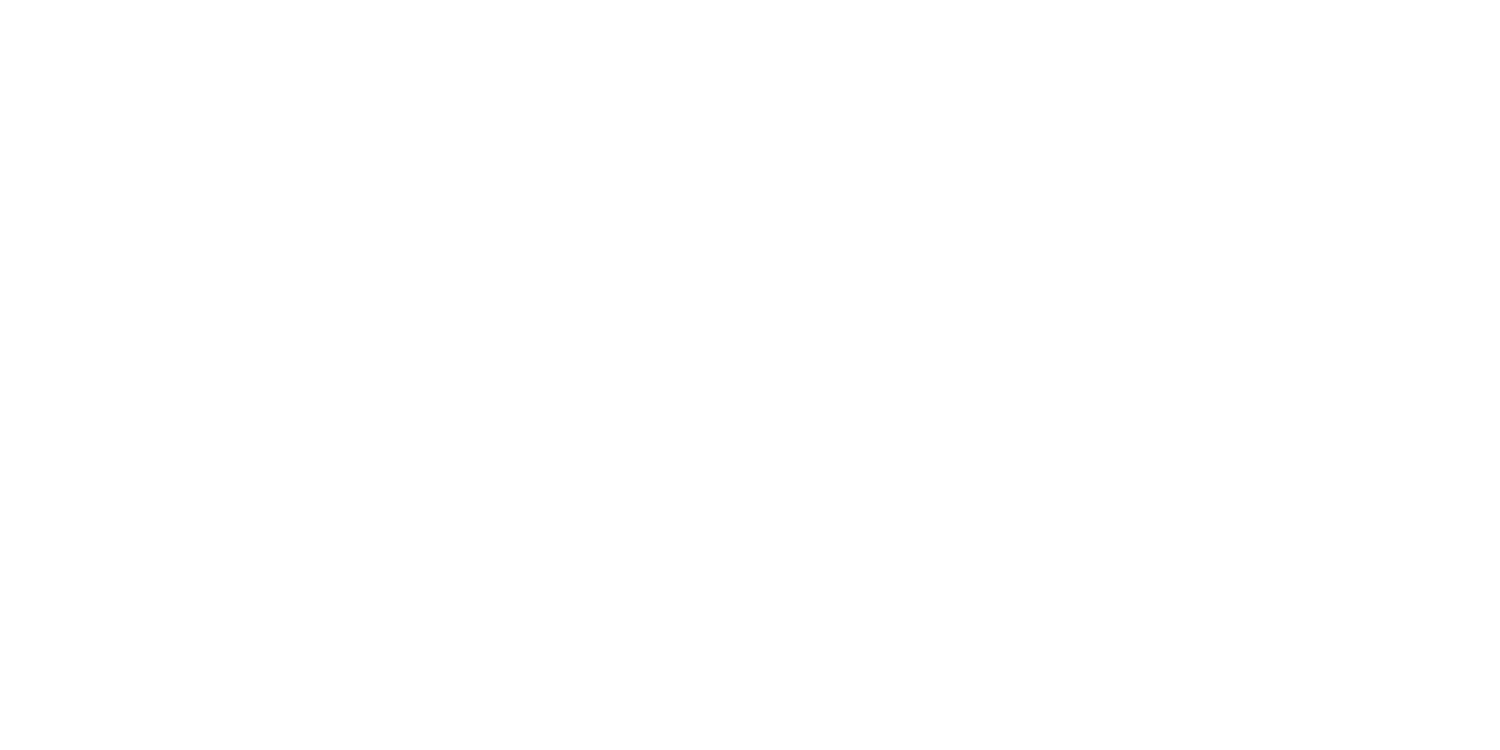

<IPython.core.display.Javascript object>


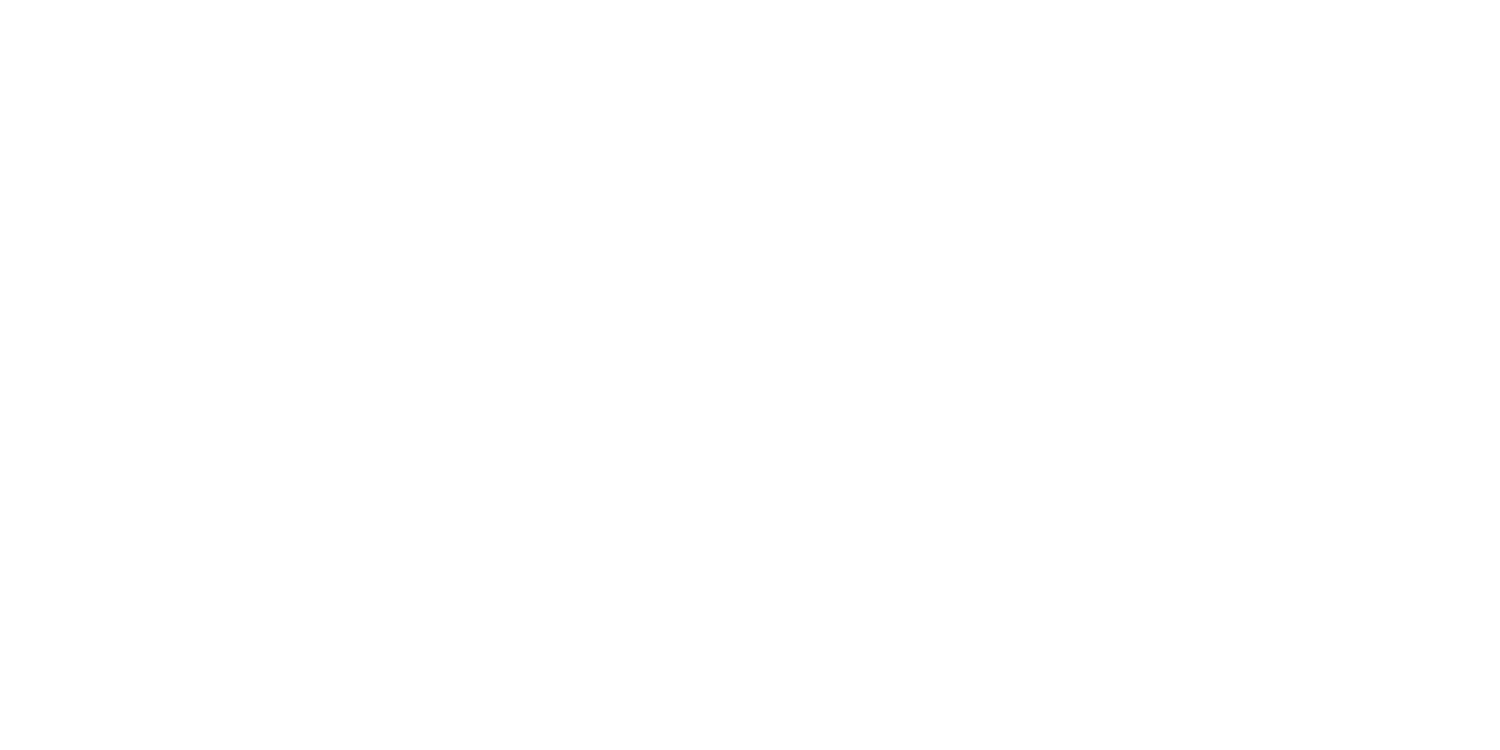

<IPython.core.display.Javascript object>


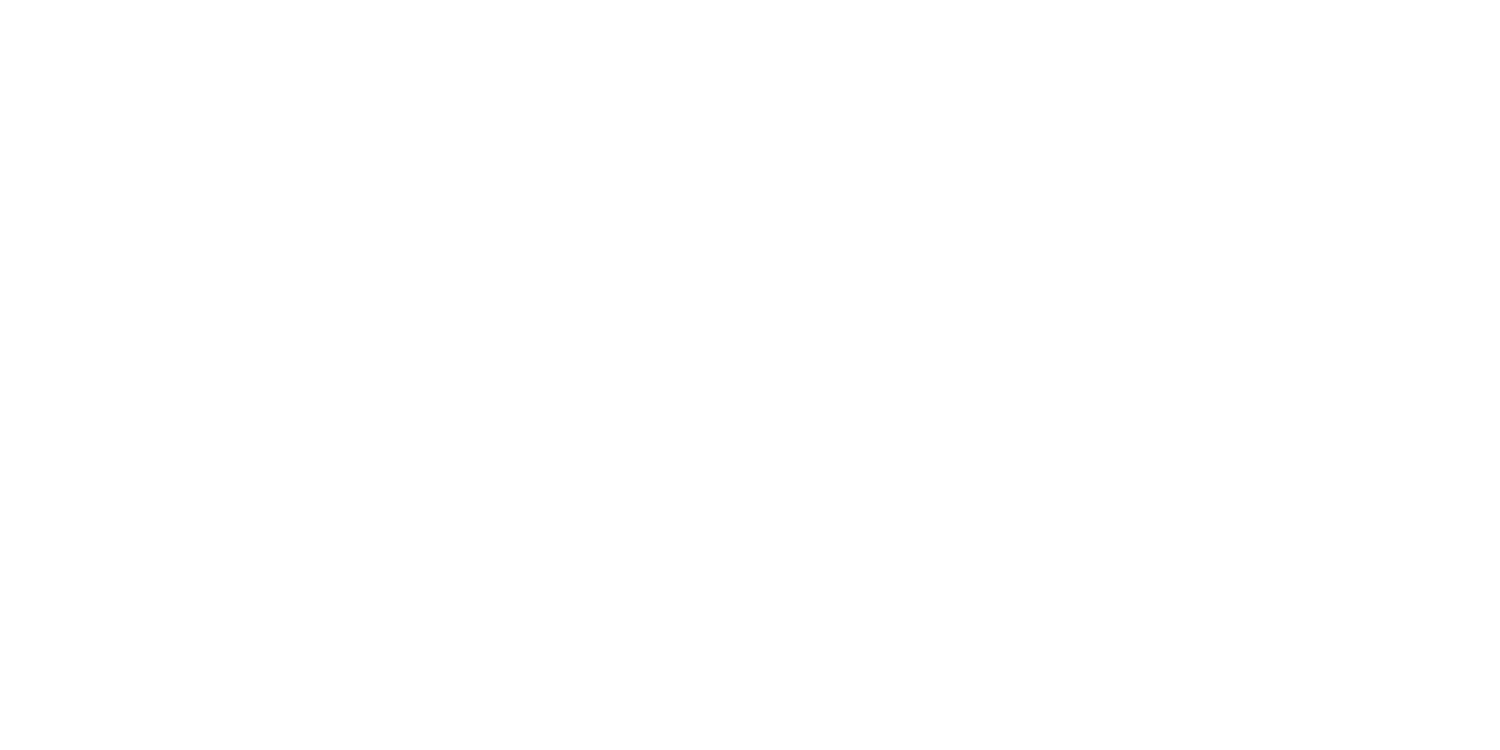

<IPython.core.display.Javascript object>


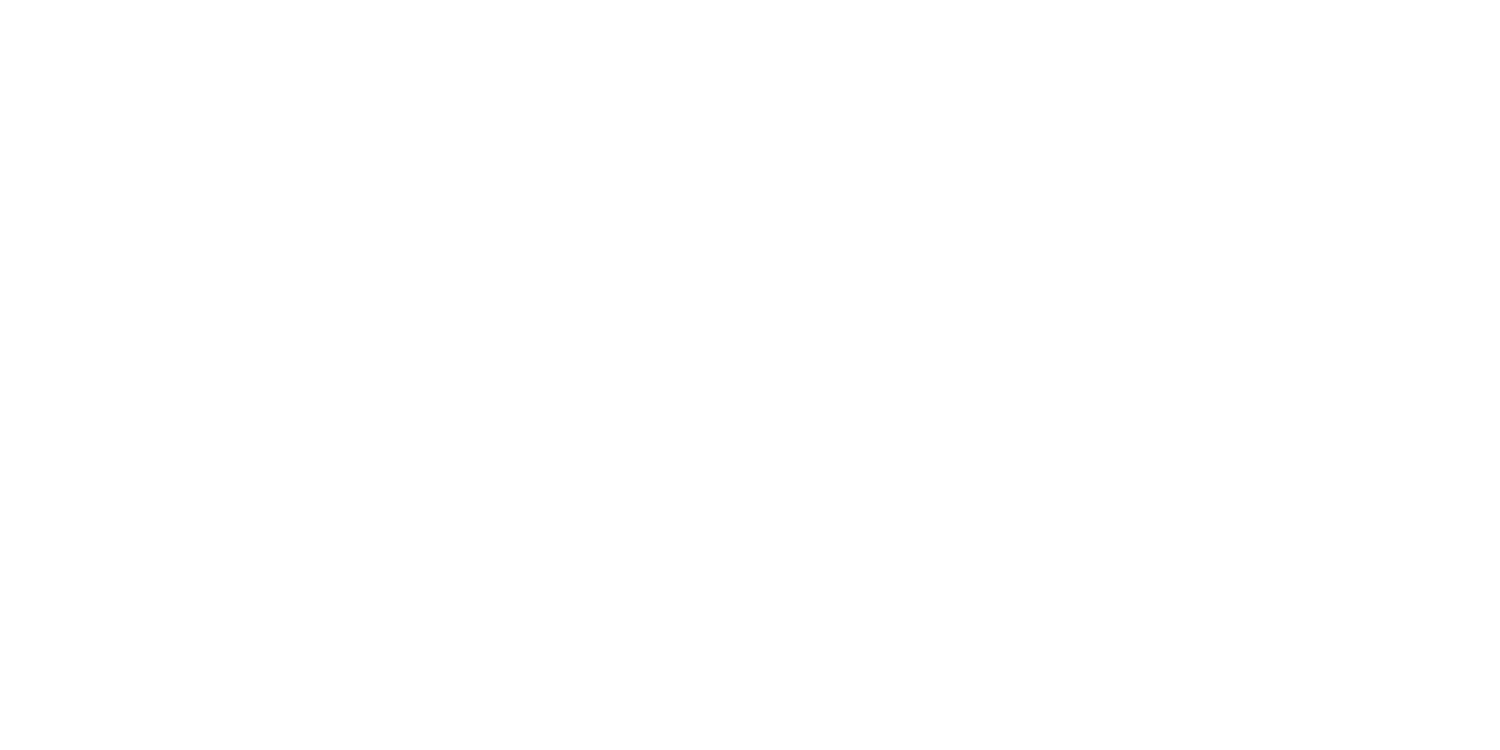

<IPython.core.display.Javascript object>


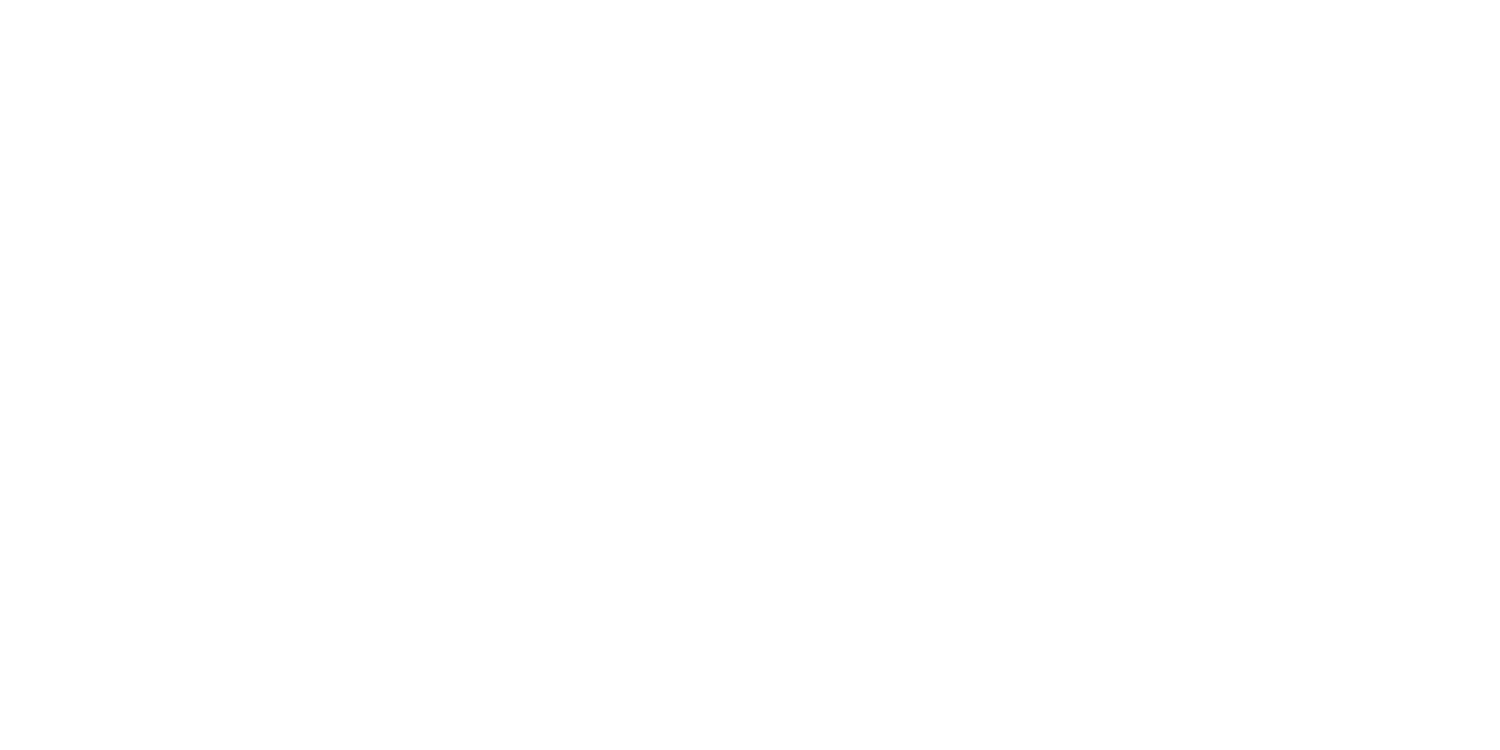

<IPython.core.display.Javascript object>


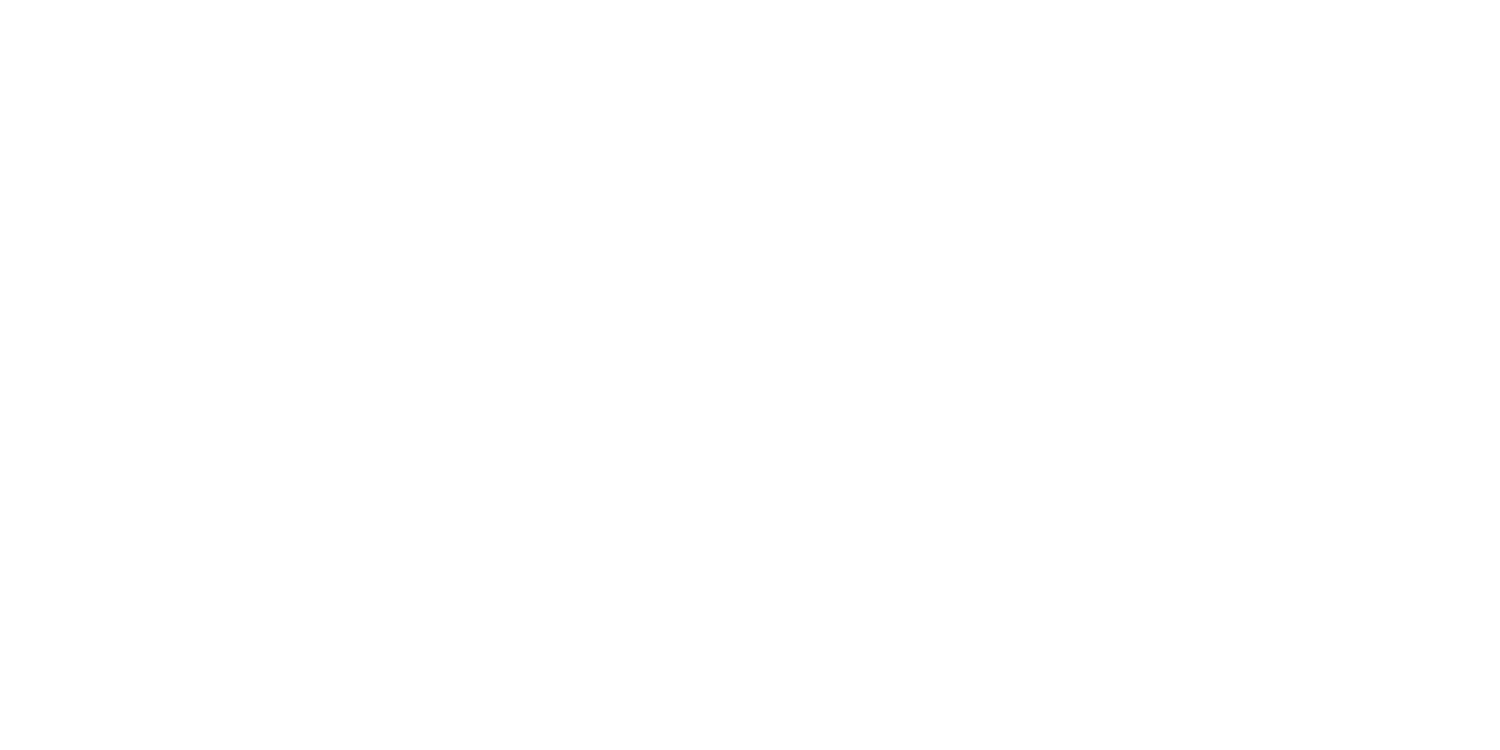

<IPython.core.display.Javascript object>


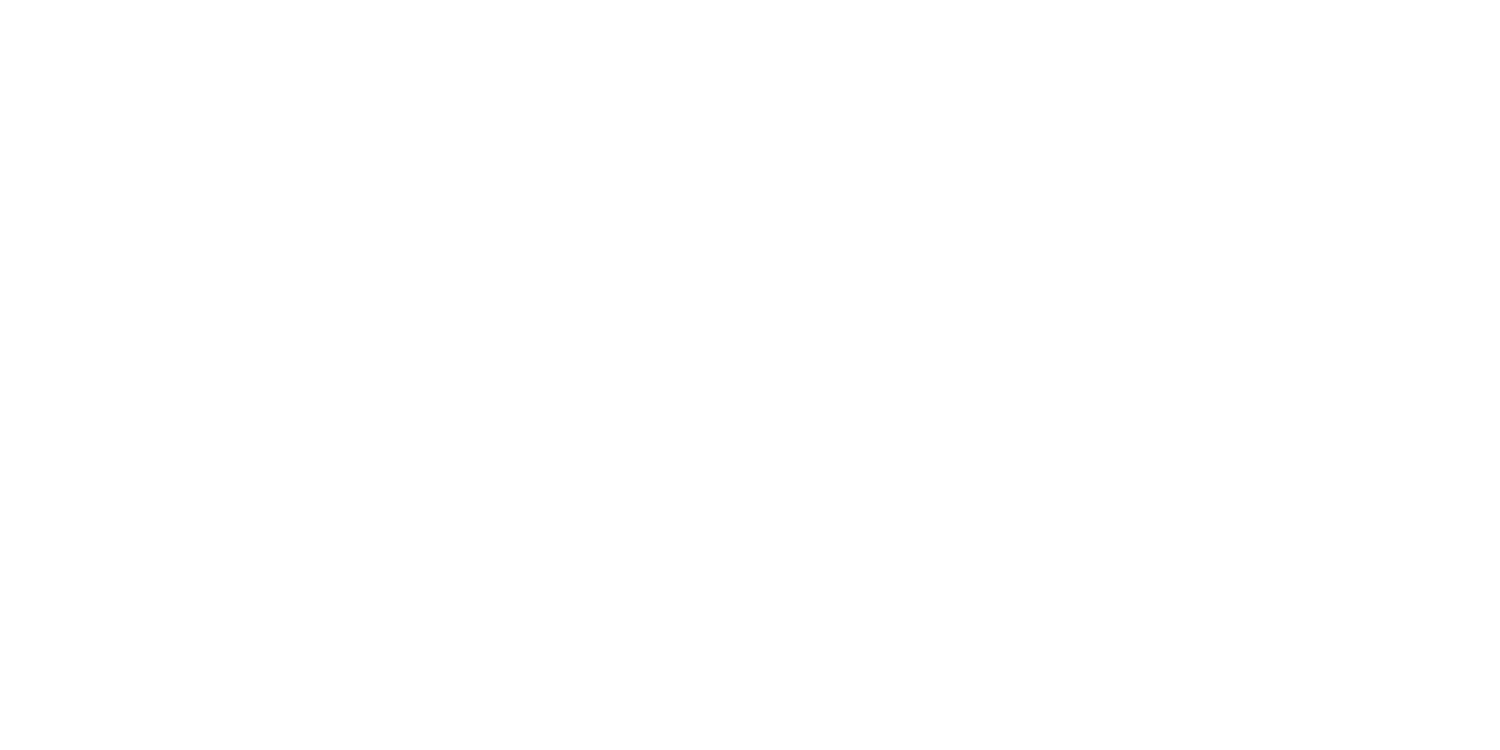

<IPython.core.display.Javascript object>


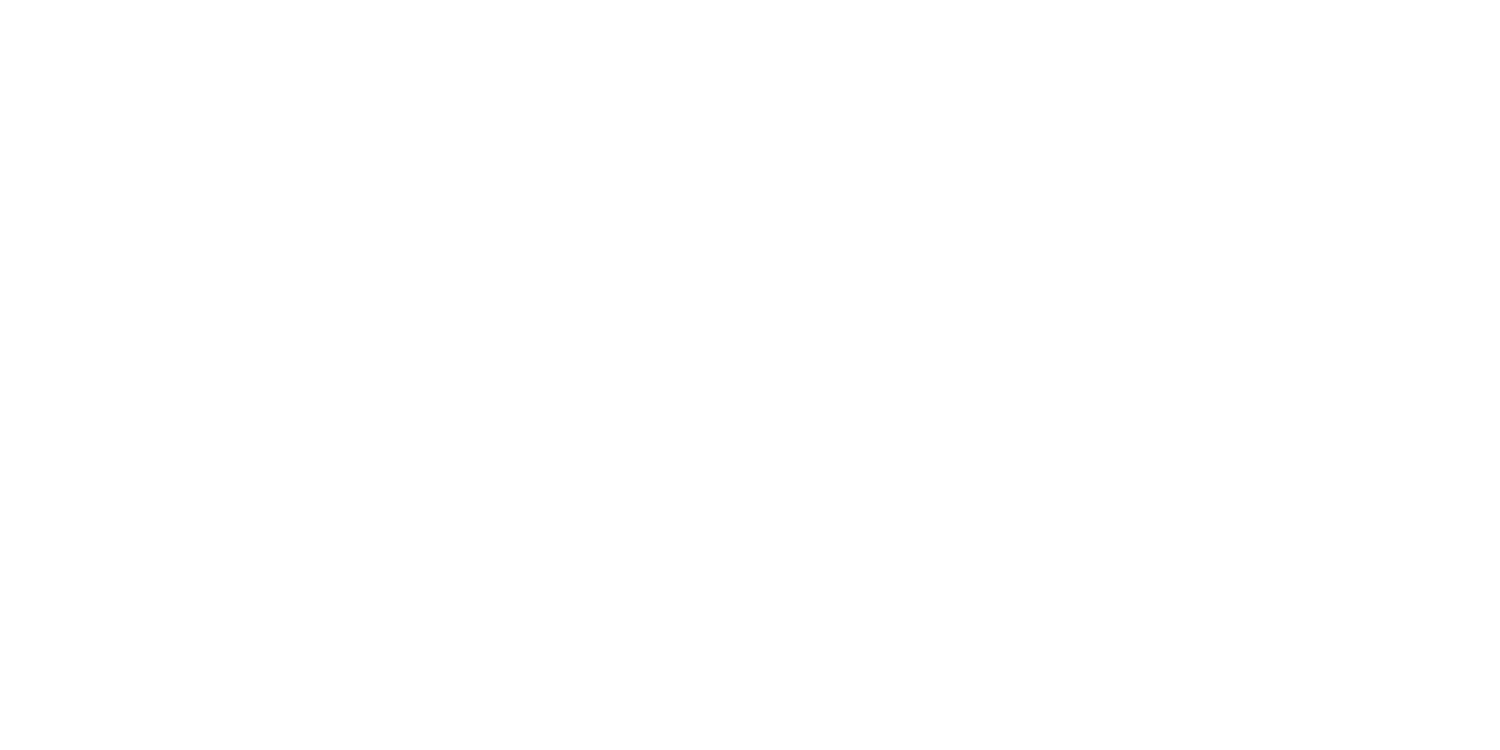

<IPython.core.display.Javascript object>


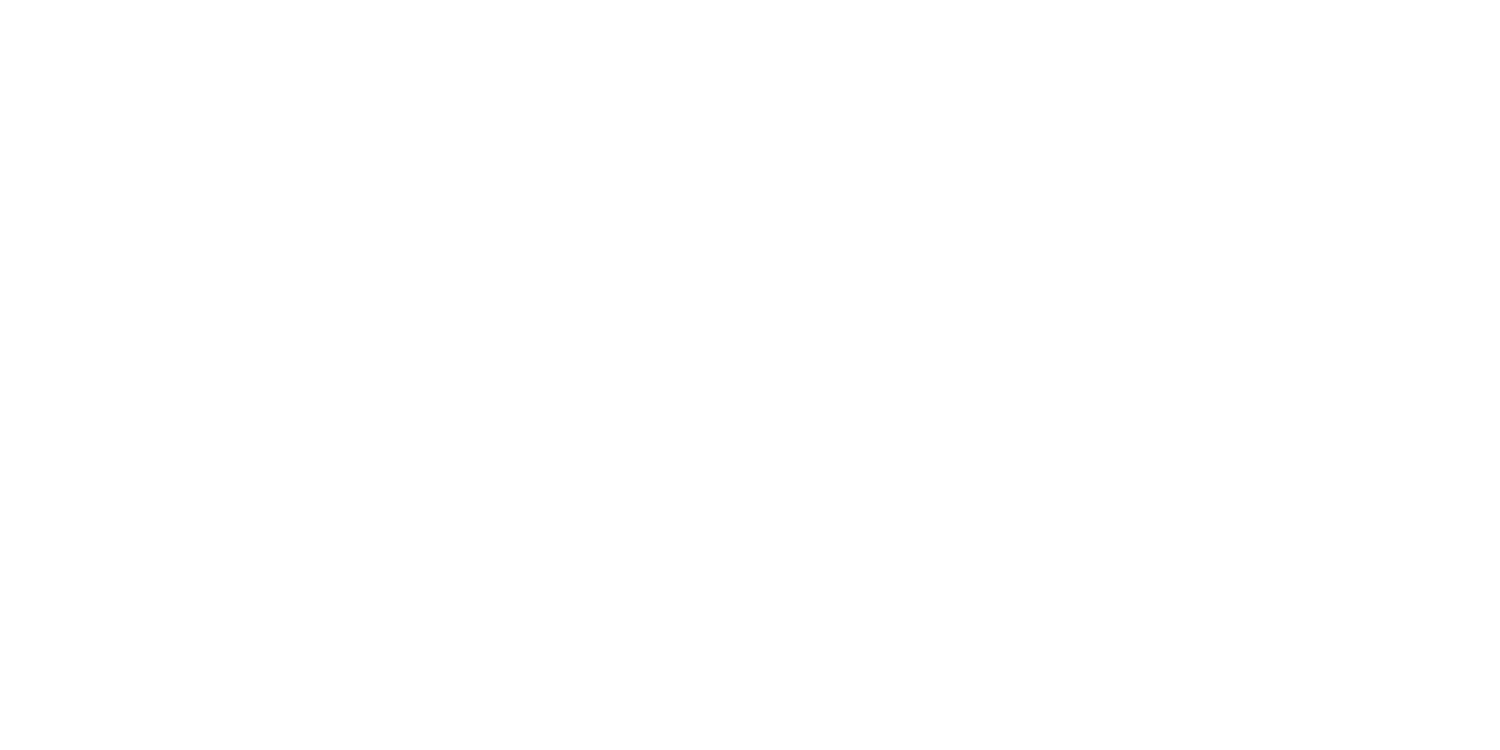

<IPython.core.display.Javascript object>


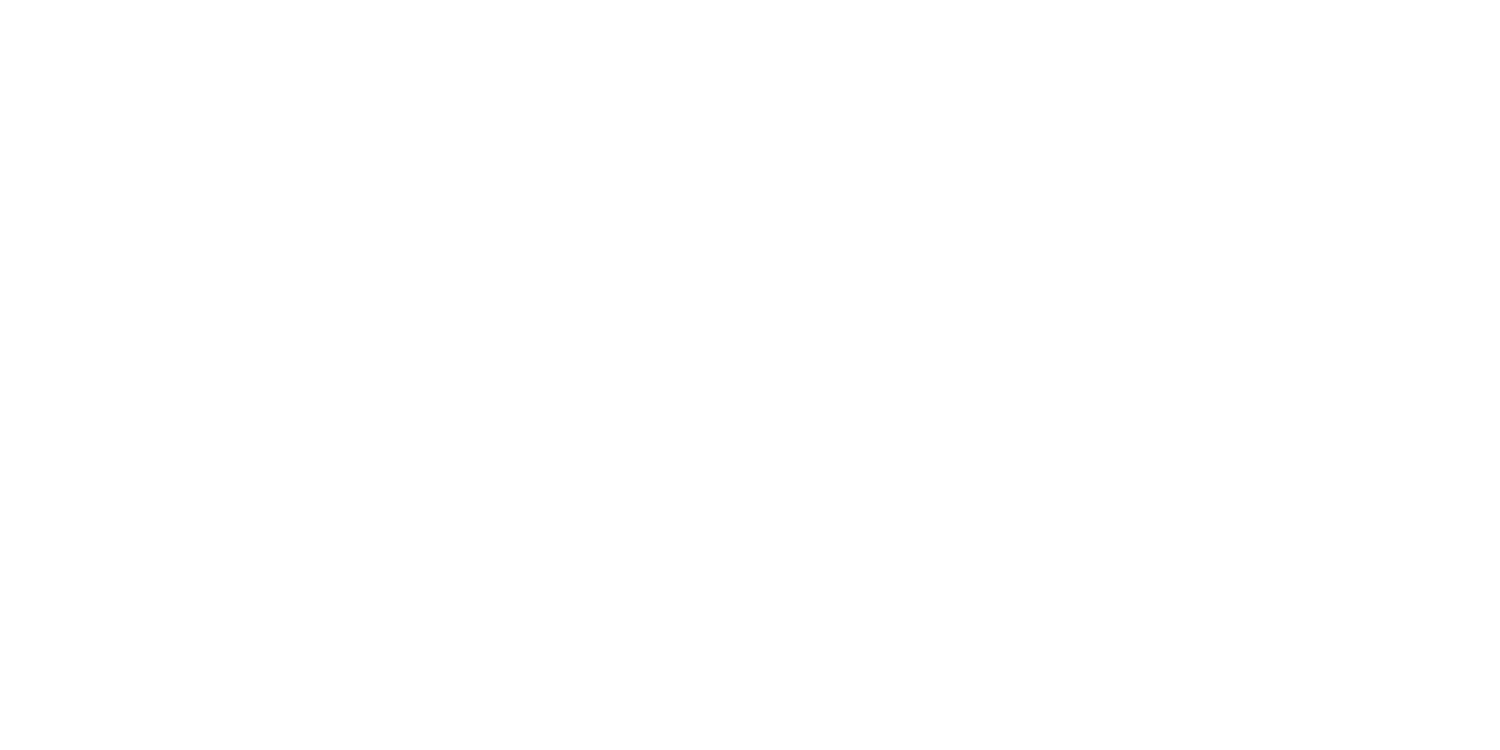

<IPython.core.display.Javascript object>


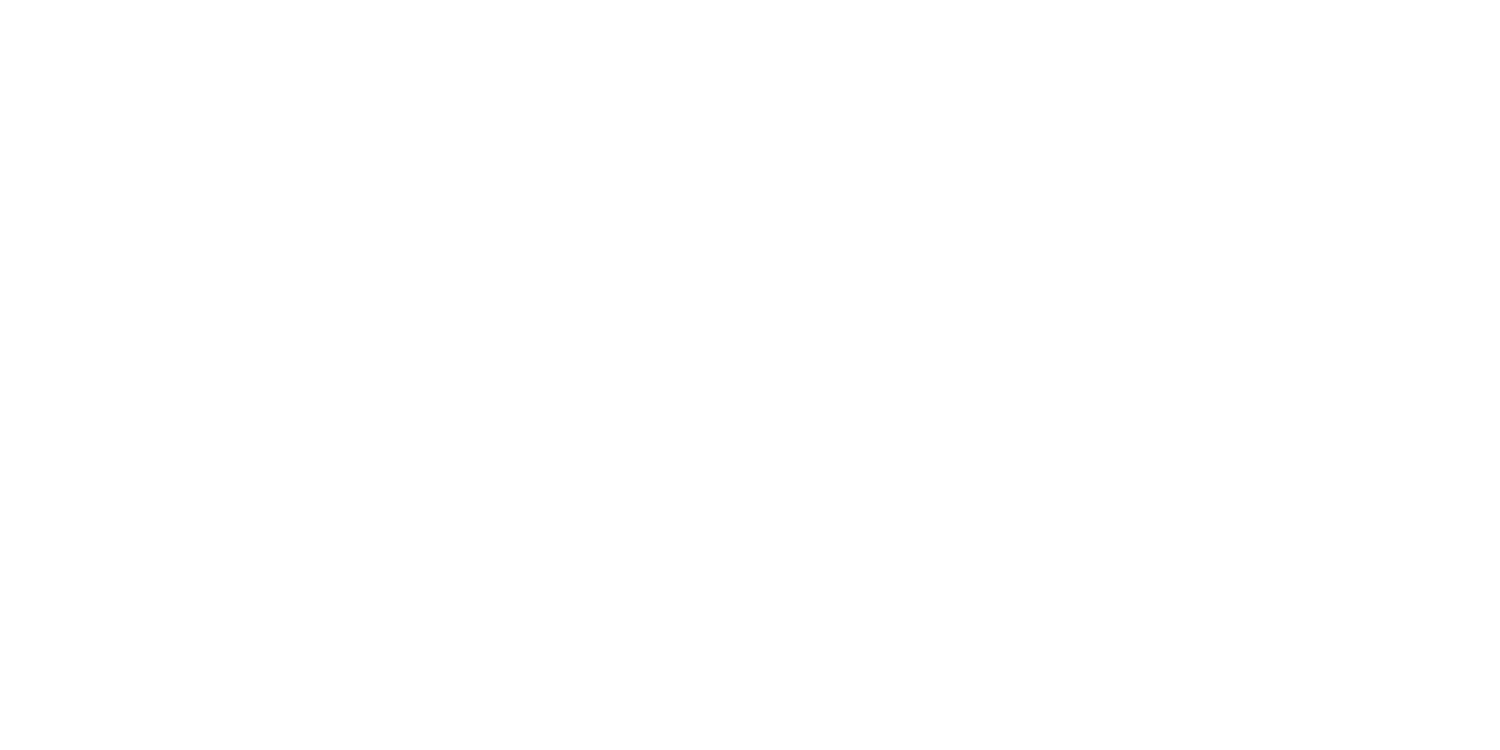

<IPython.core.display.Javascript object>


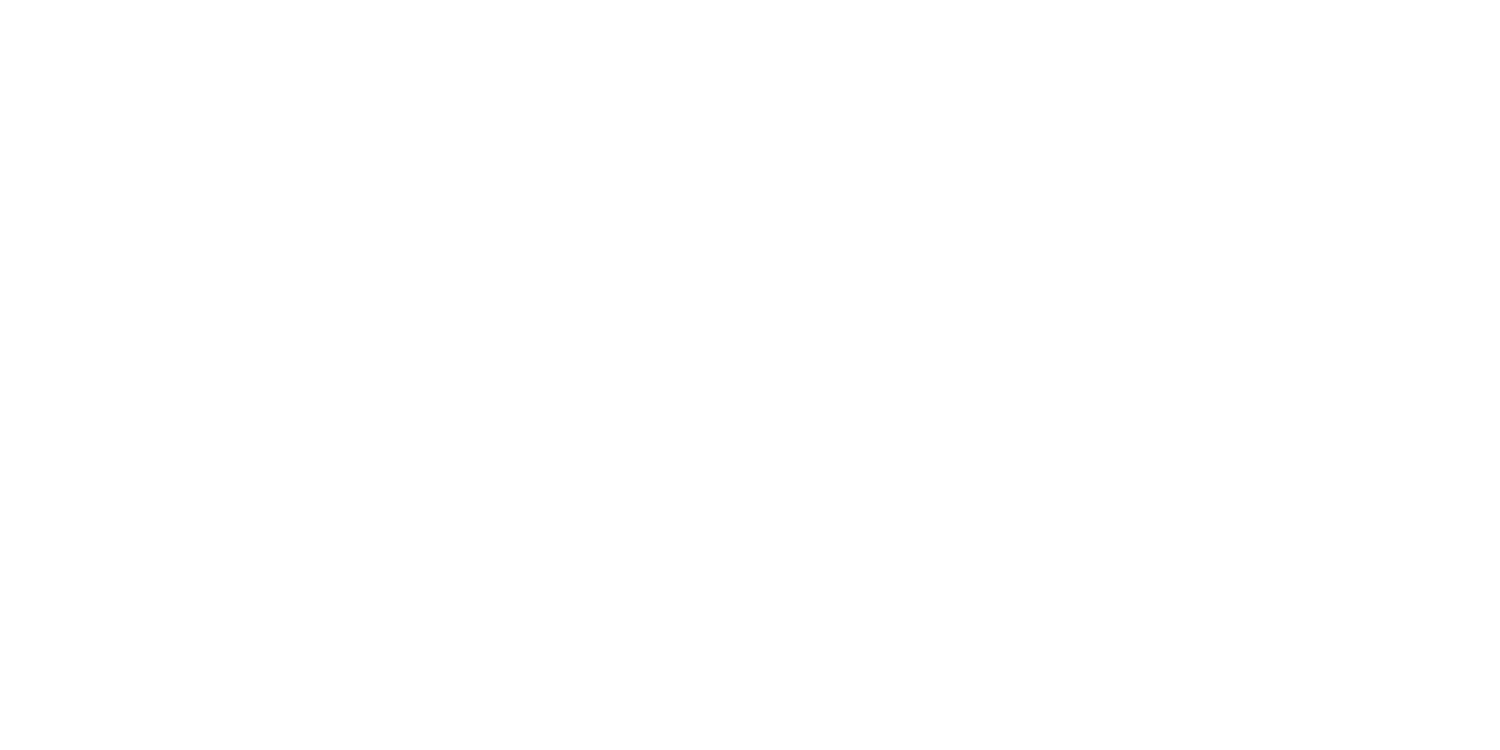

<IPython.core.display.Javascript object>


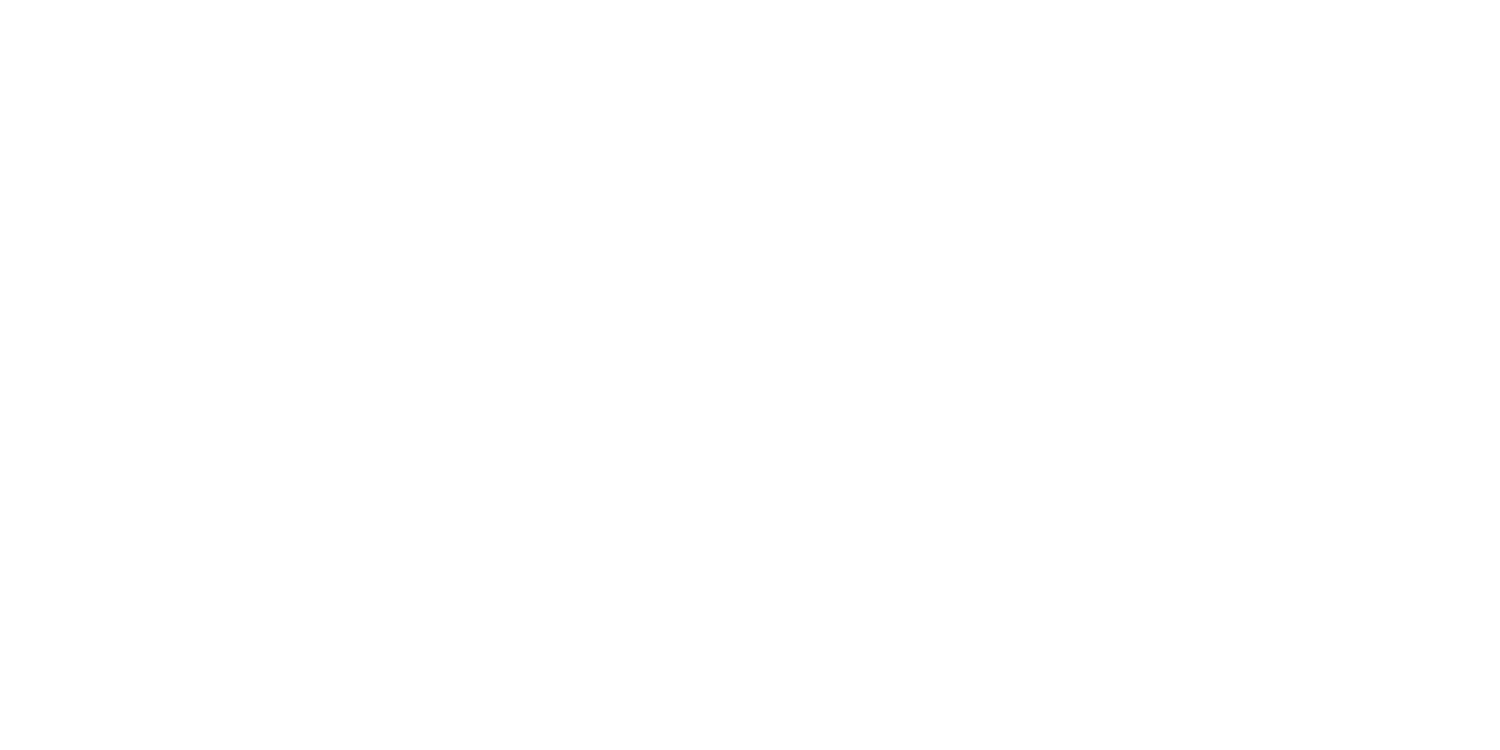

<IPython.core.display.Javascript object>


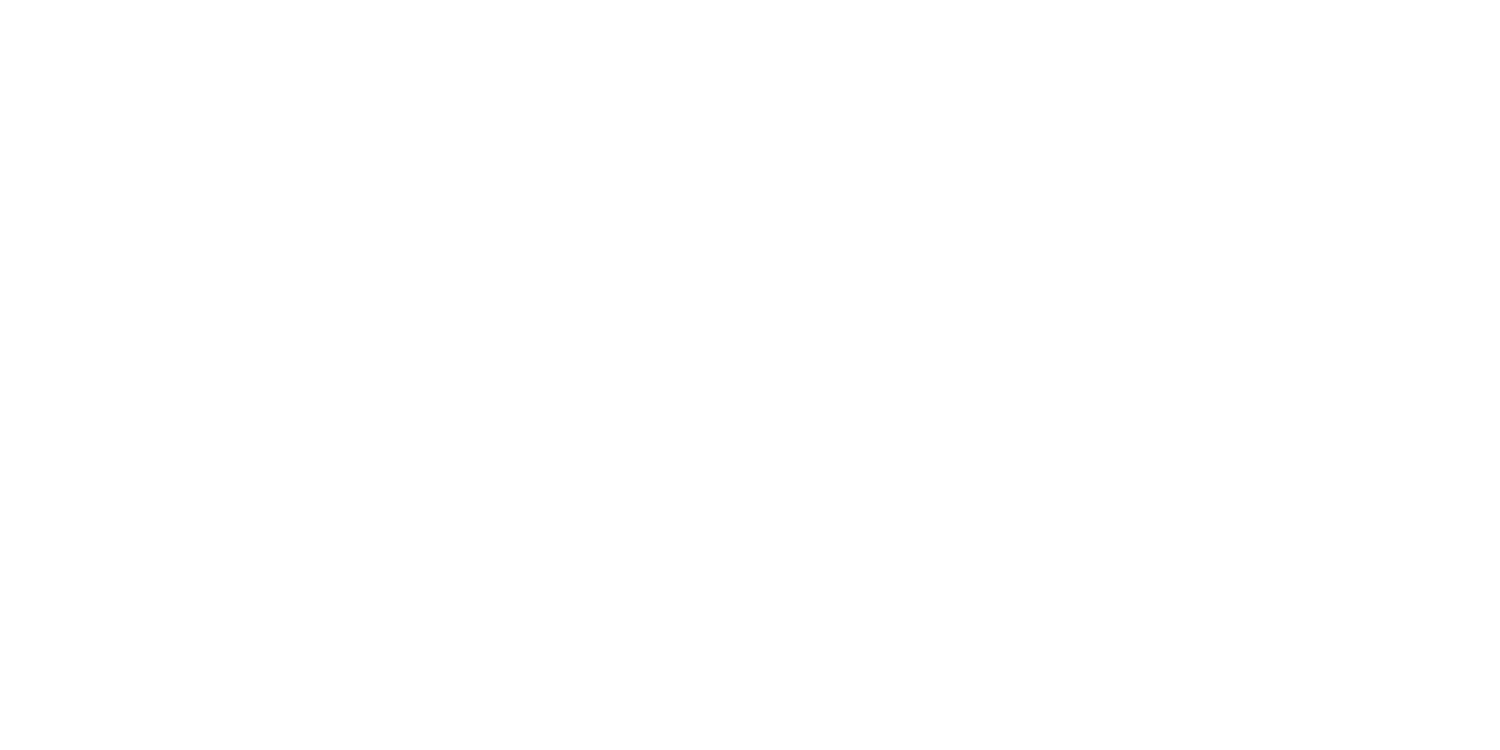

<IPython.core.display.Javascript object>


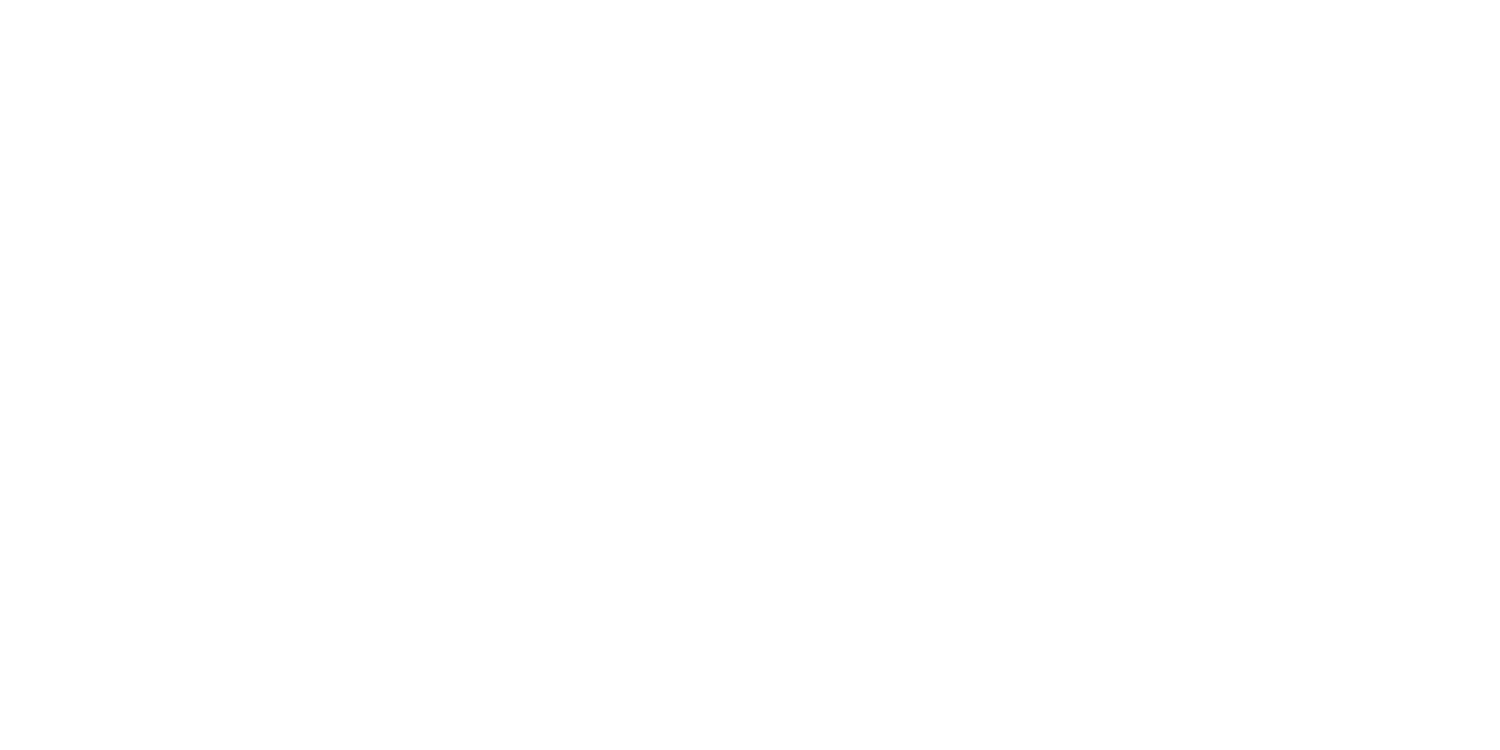

<IPython.core.display.Javascript object>


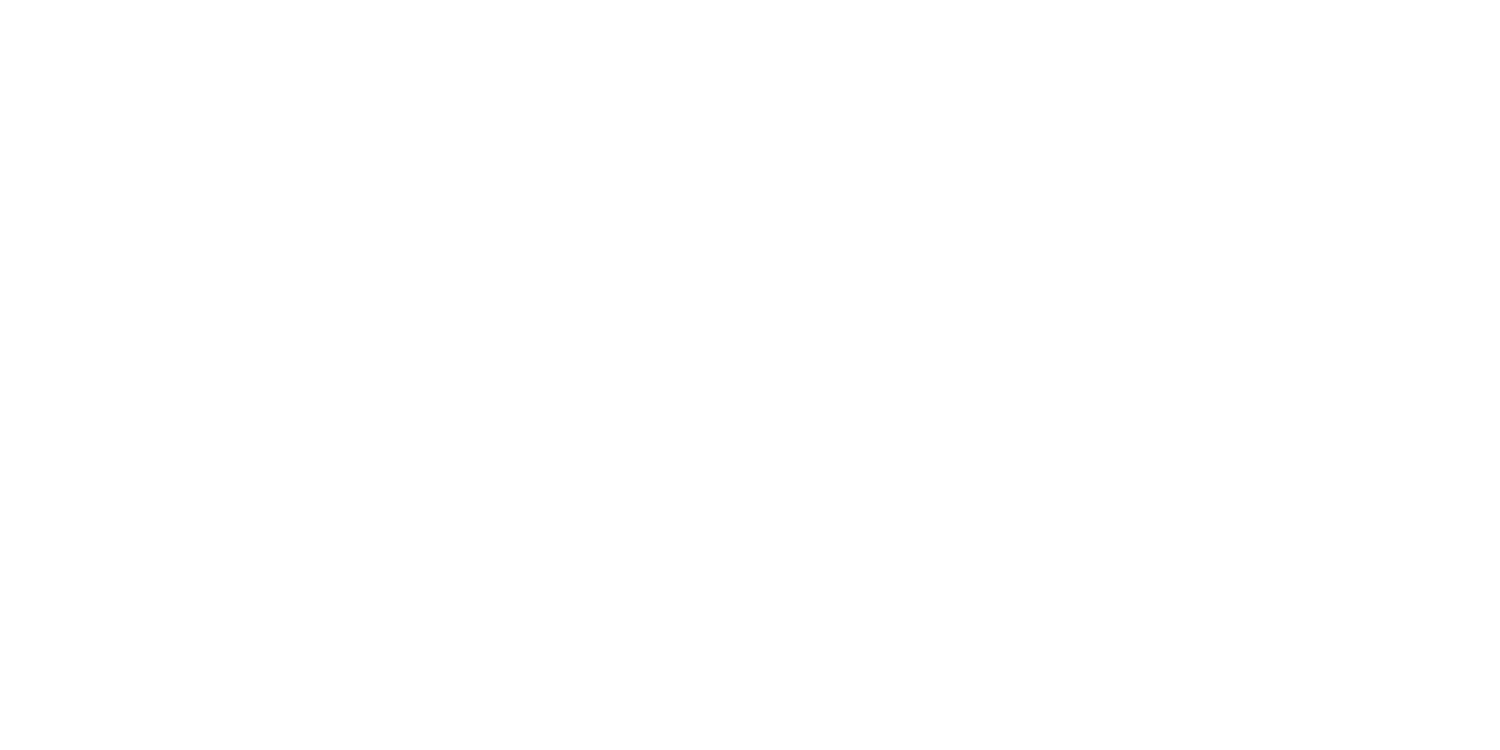

<IPython.core.display.Javascript object>


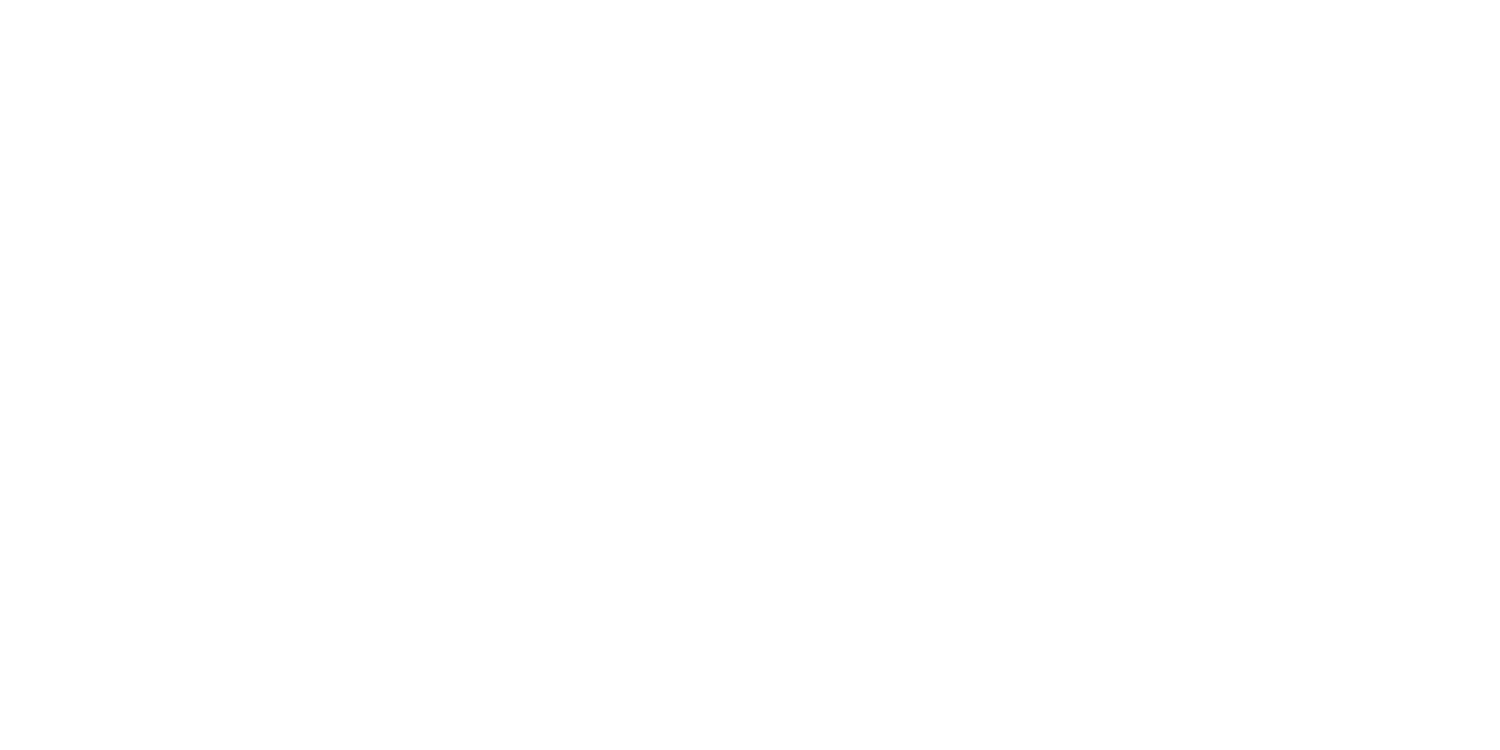

<IPython.core.display.Javascript object>


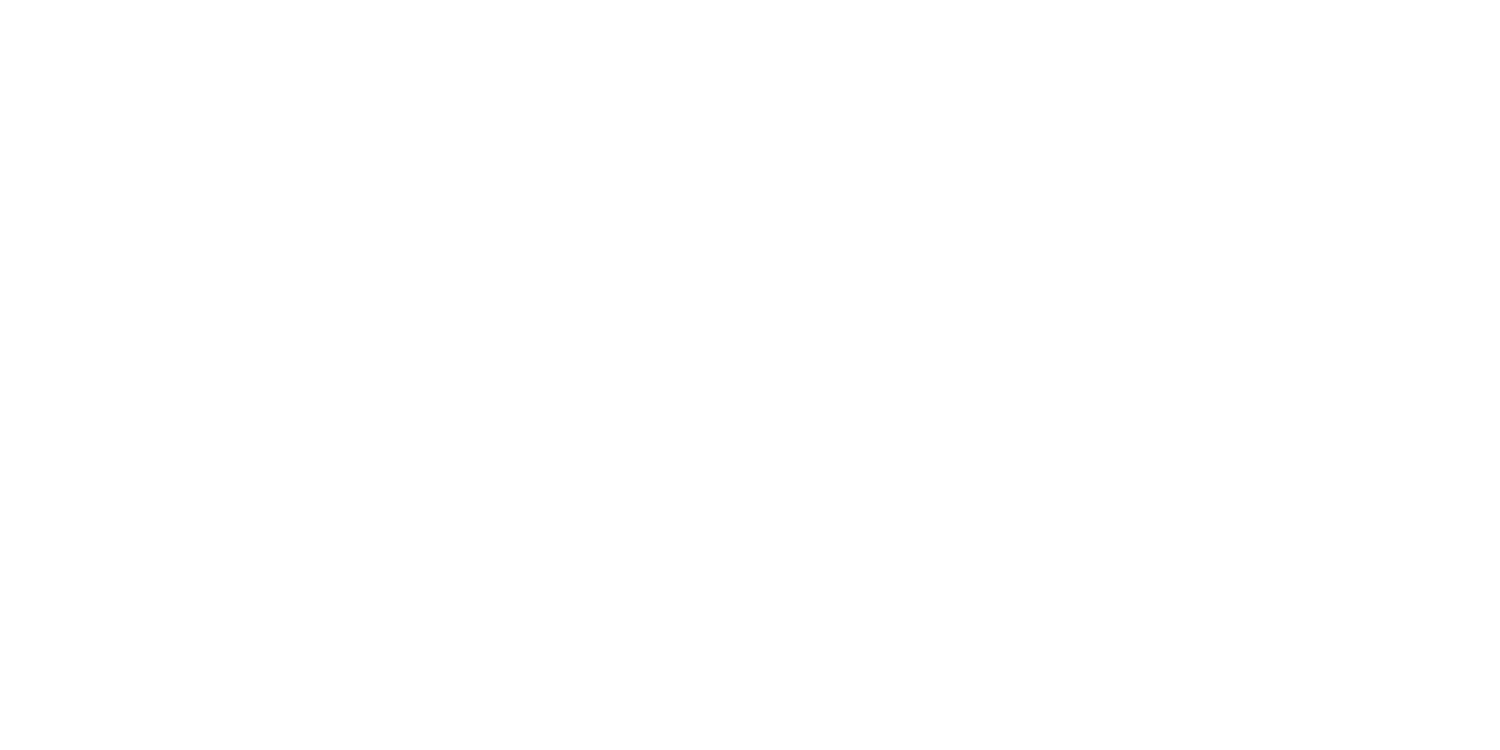

<IPython.core.display.Javascript object>


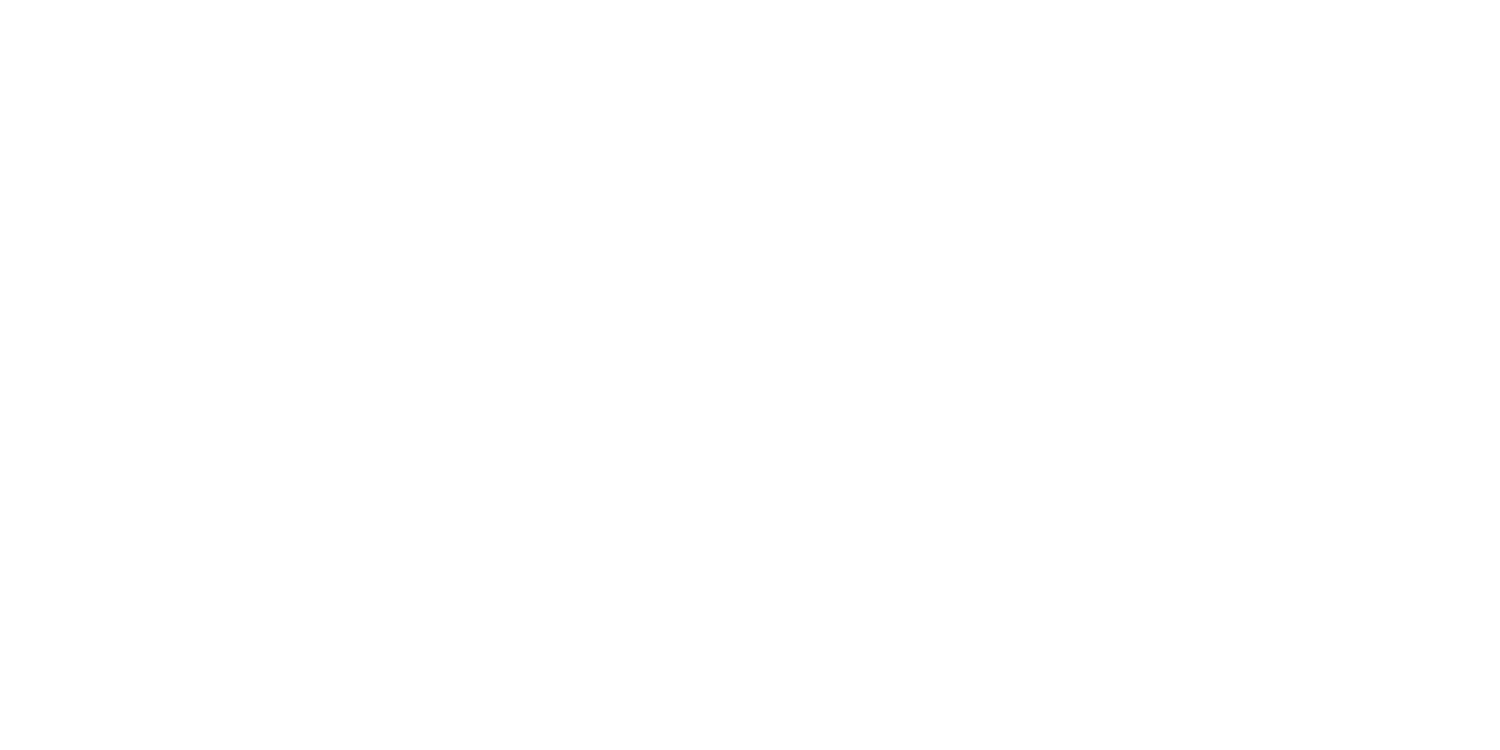

<IPython.core.display.Javascript object>


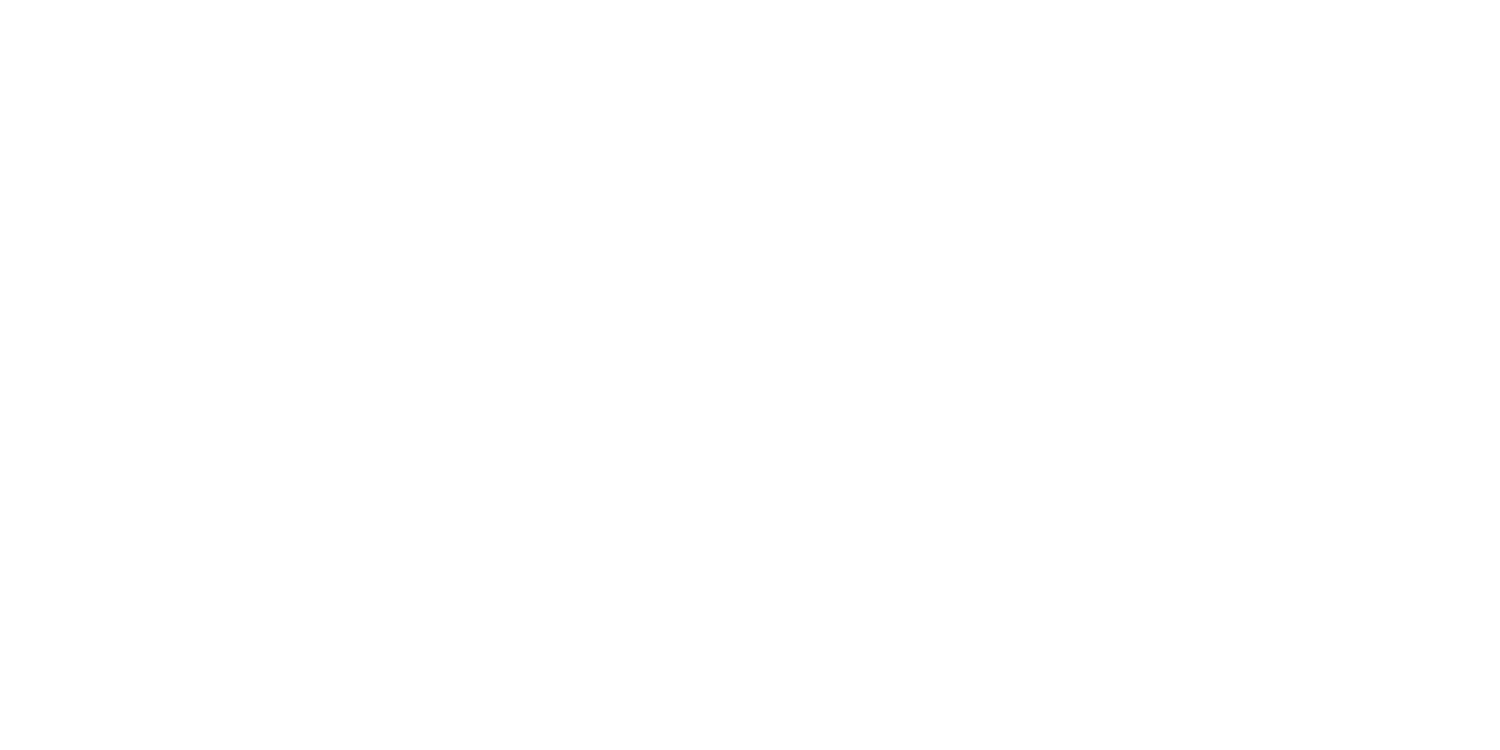

<IPython.core.display.Javascript object>


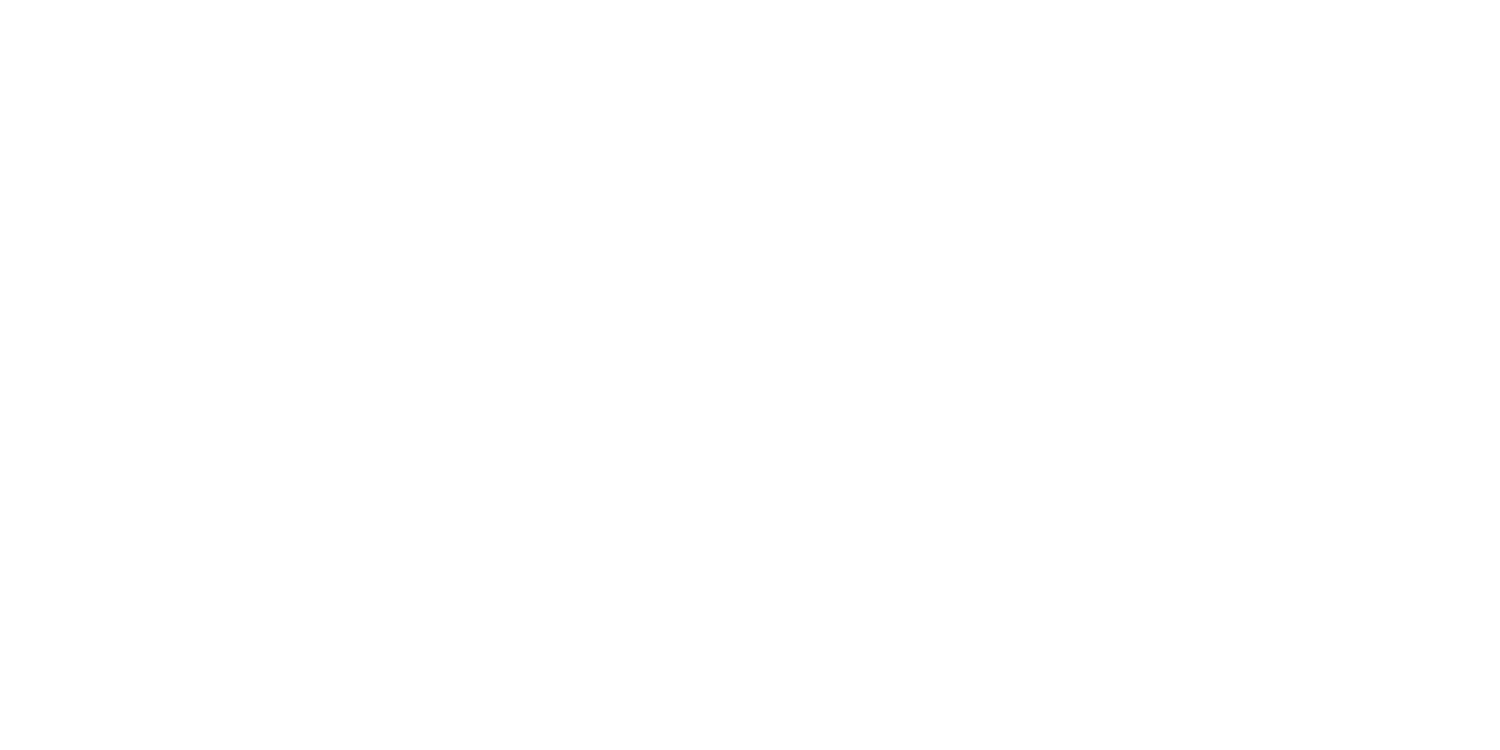

<IPython.core.display.Javascript object>


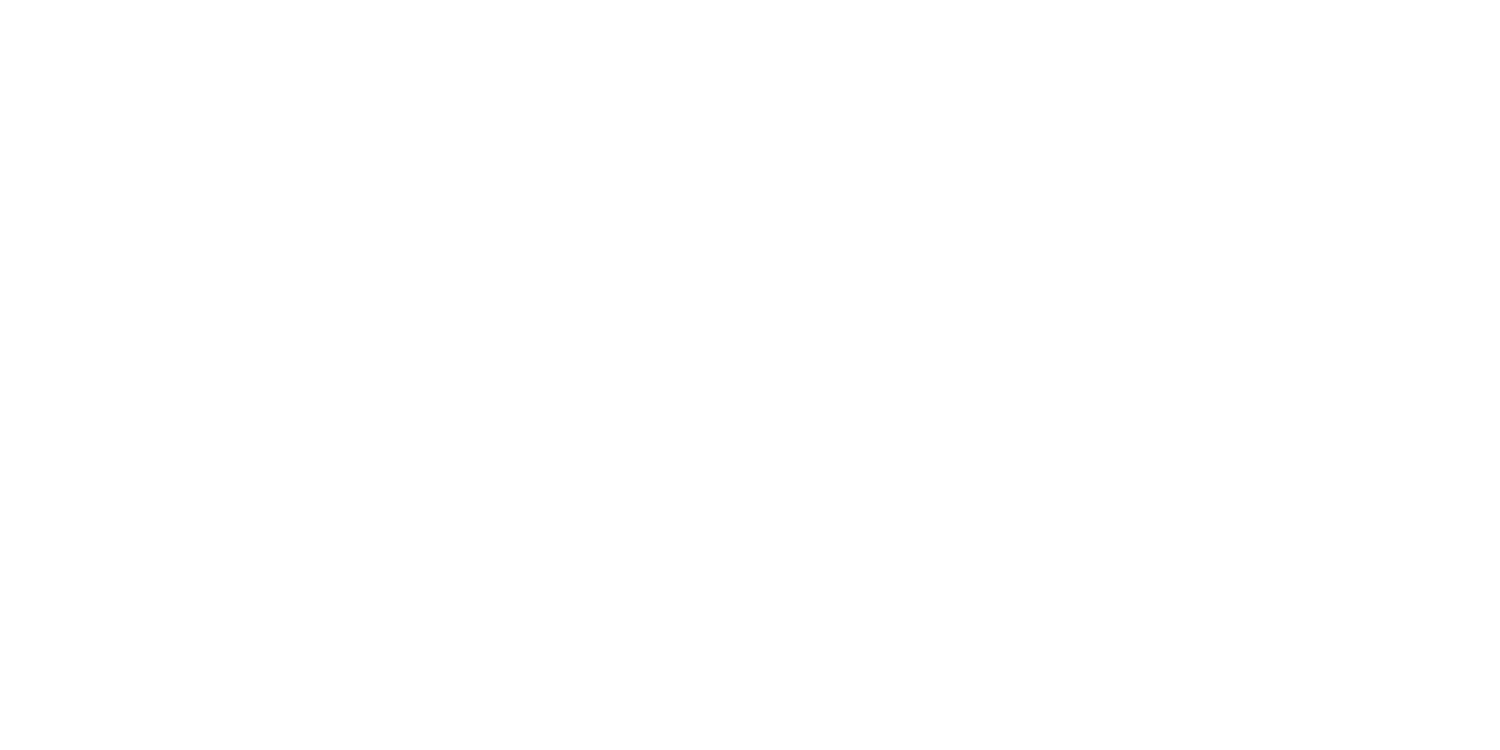

<IPython.core.display.Javascript object>


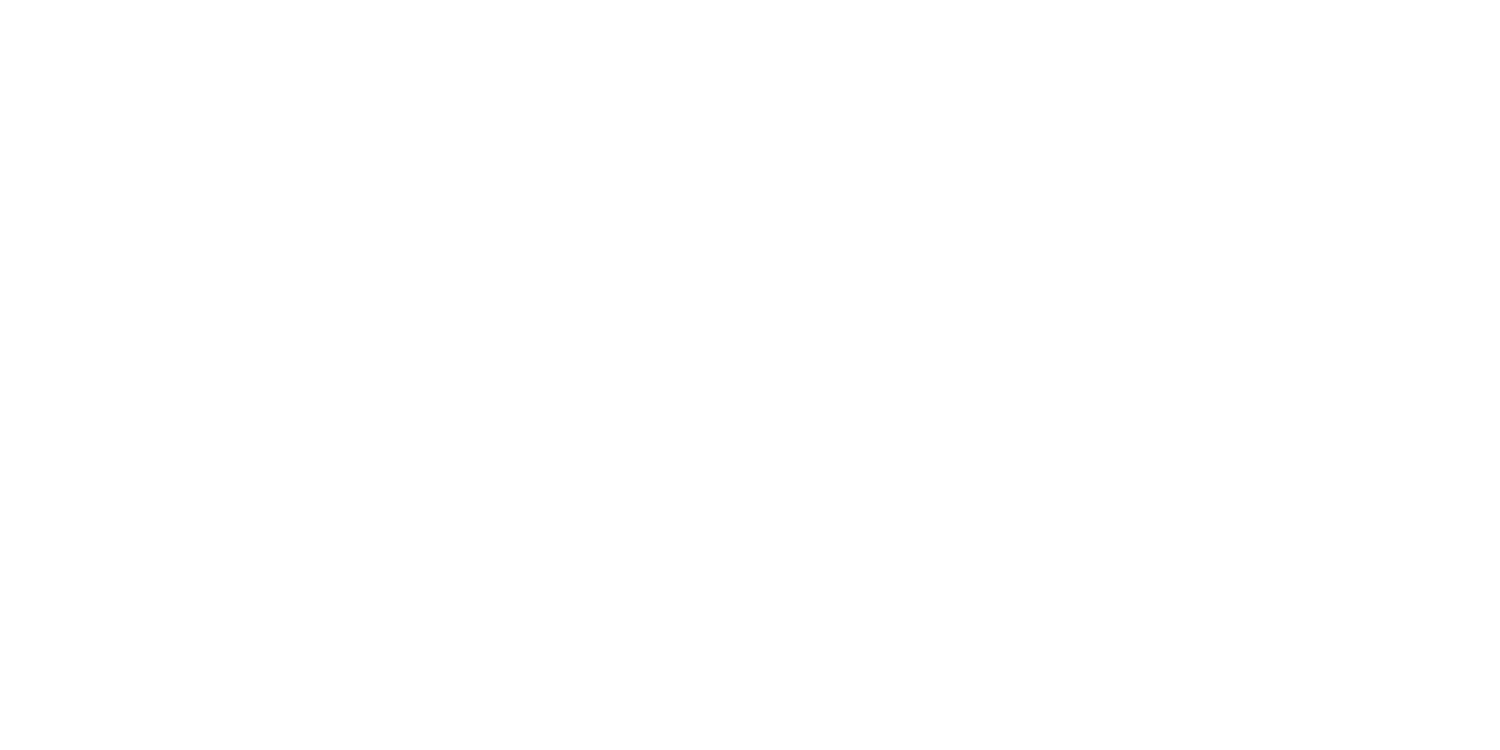

<IPython.core.display.Javascript object>


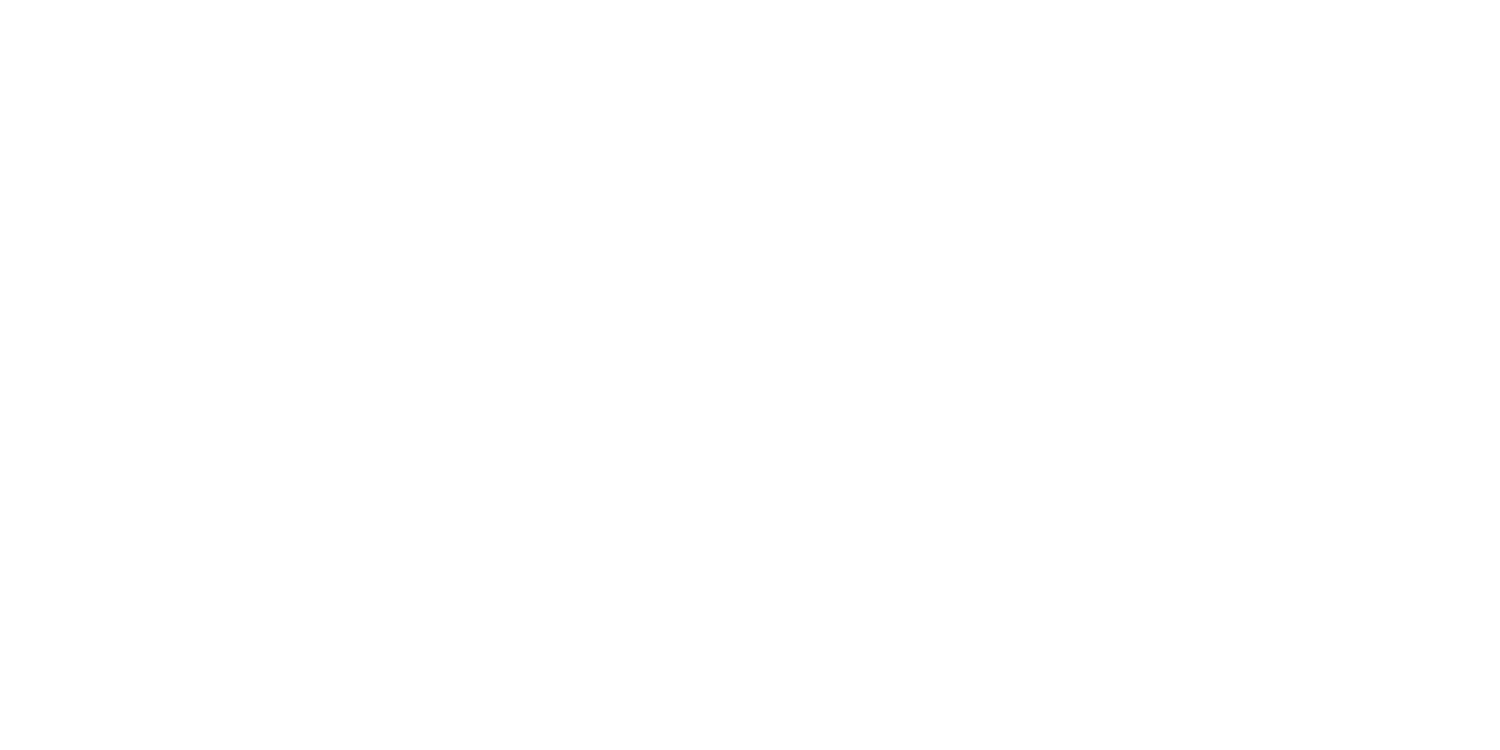

<IPython.core.display.Javascript object>


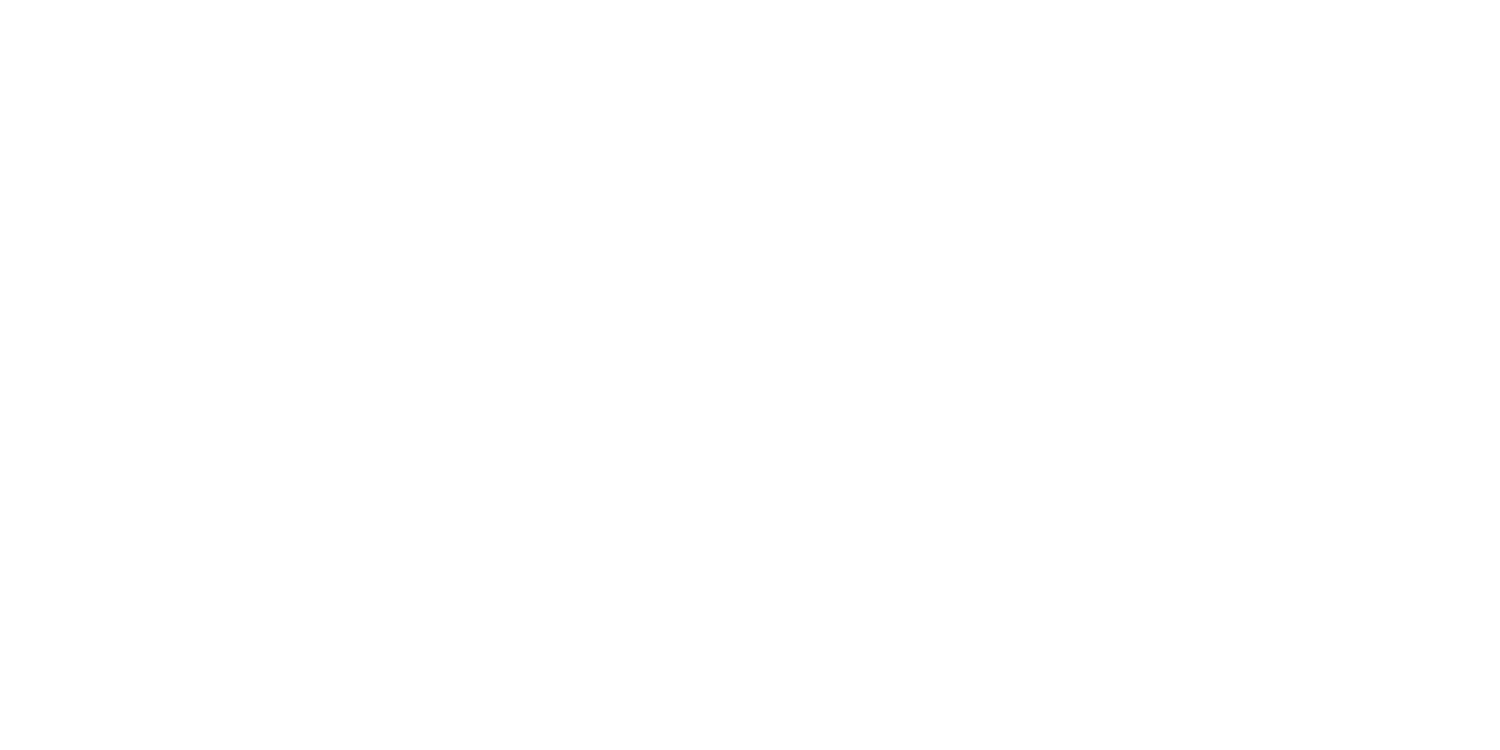

<IPython.core.display.Javascript object>


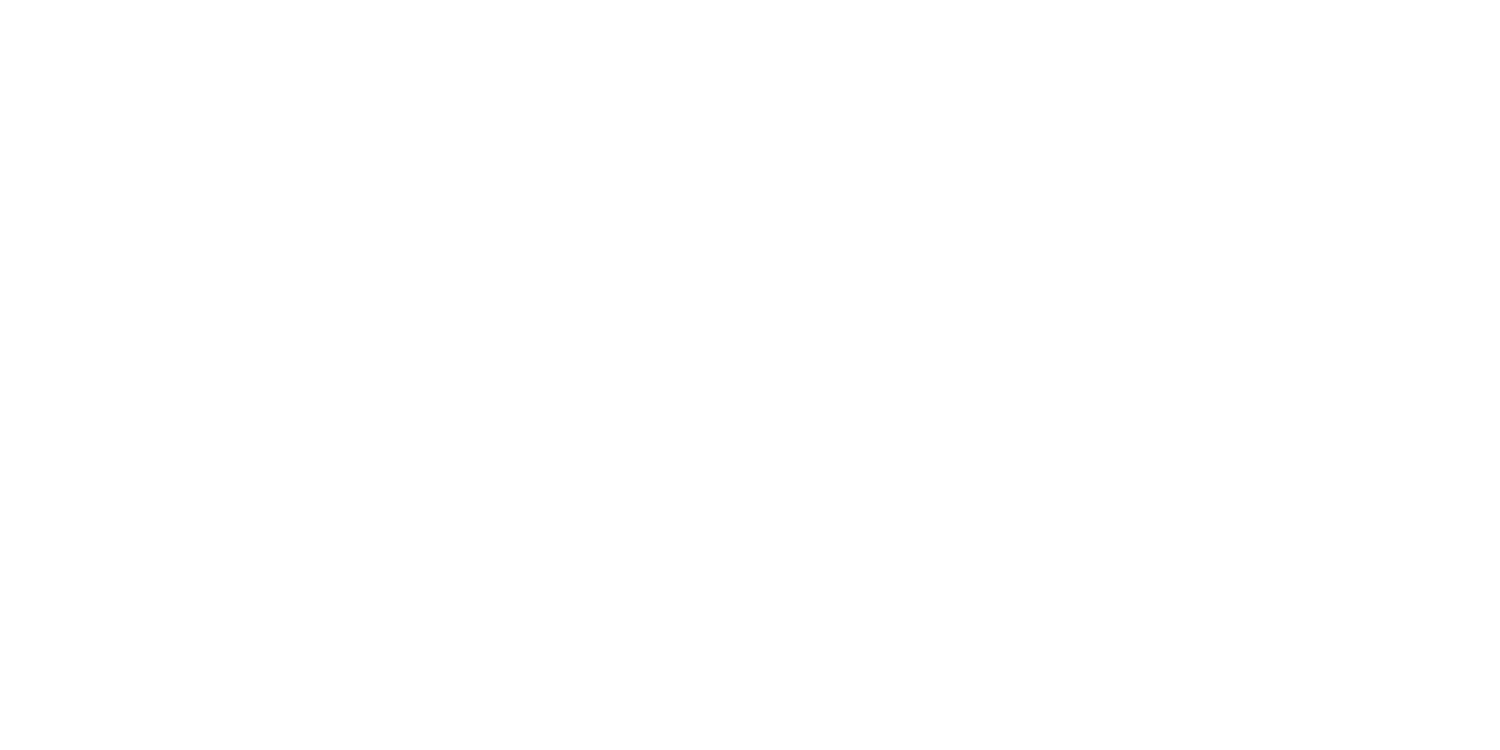

<IPython.core.display.Javascript object>


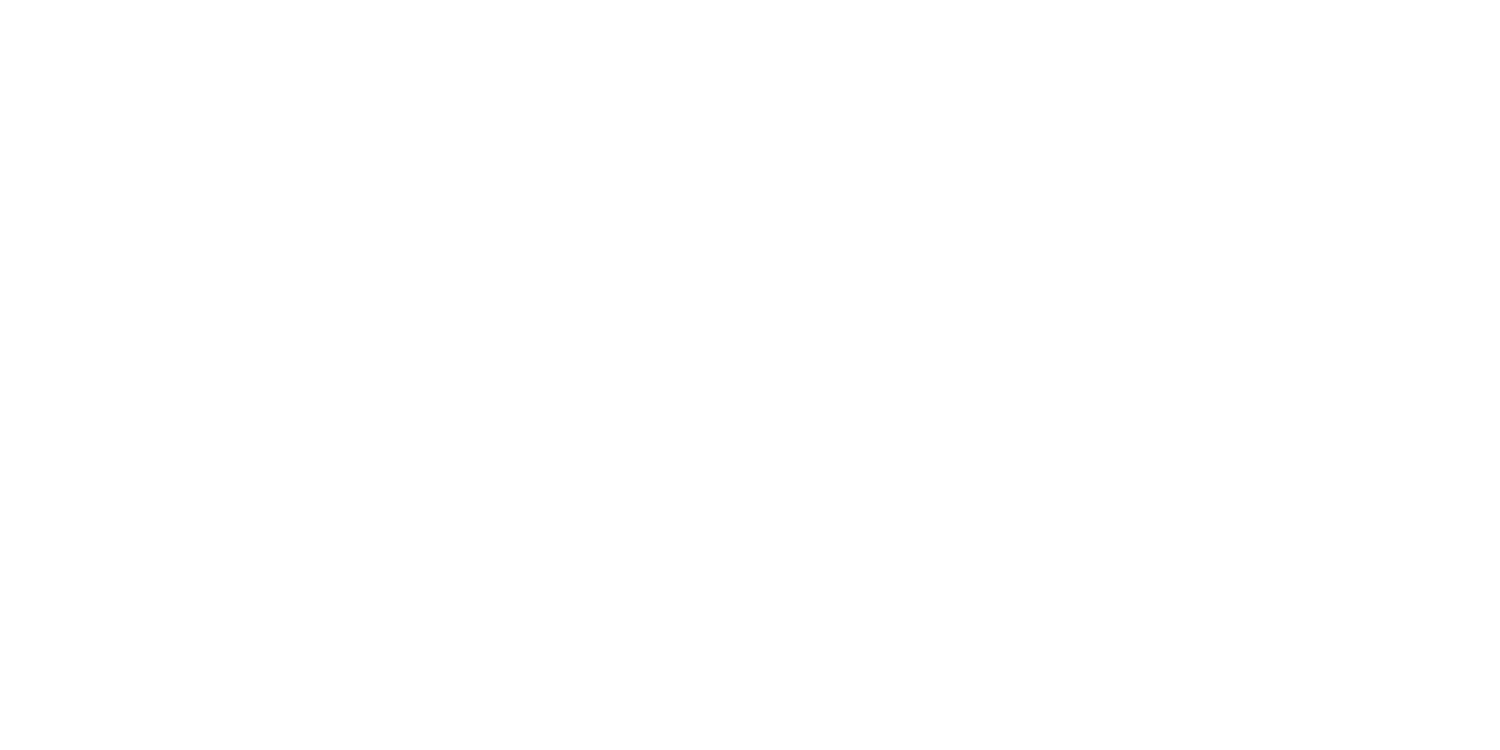

<IPython.core.display.Javascript object>


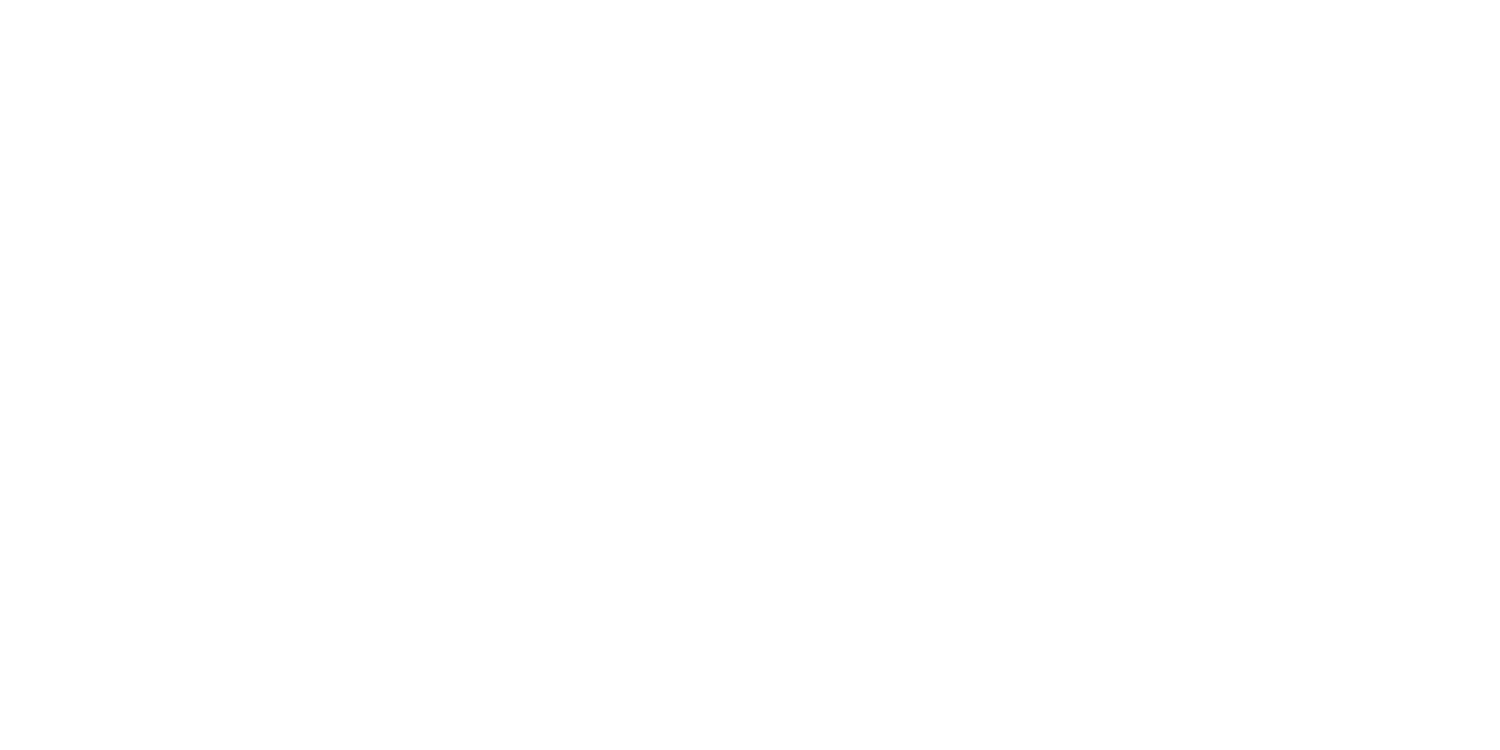

<IPython.core.display.Javascript object>


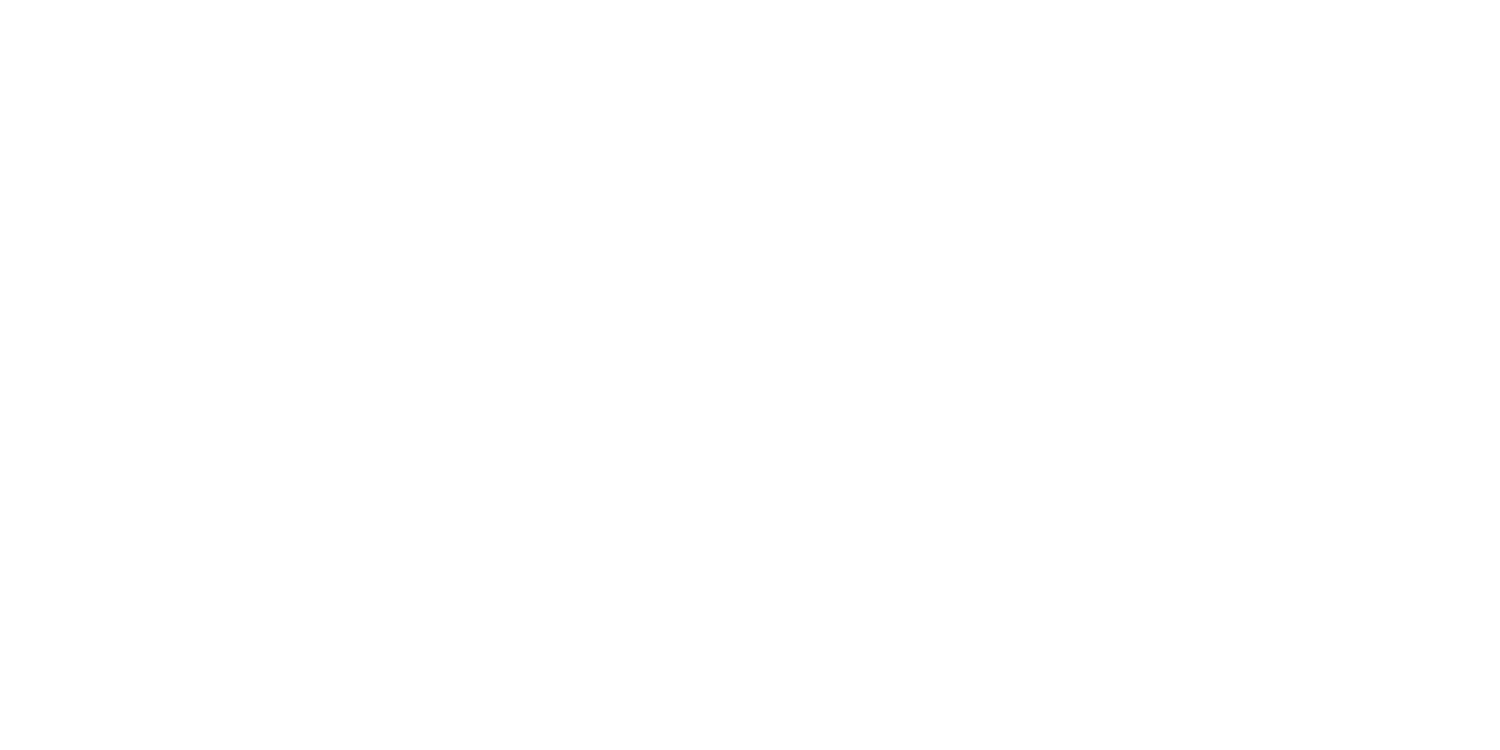

<IPython.core.display.Javascript object>


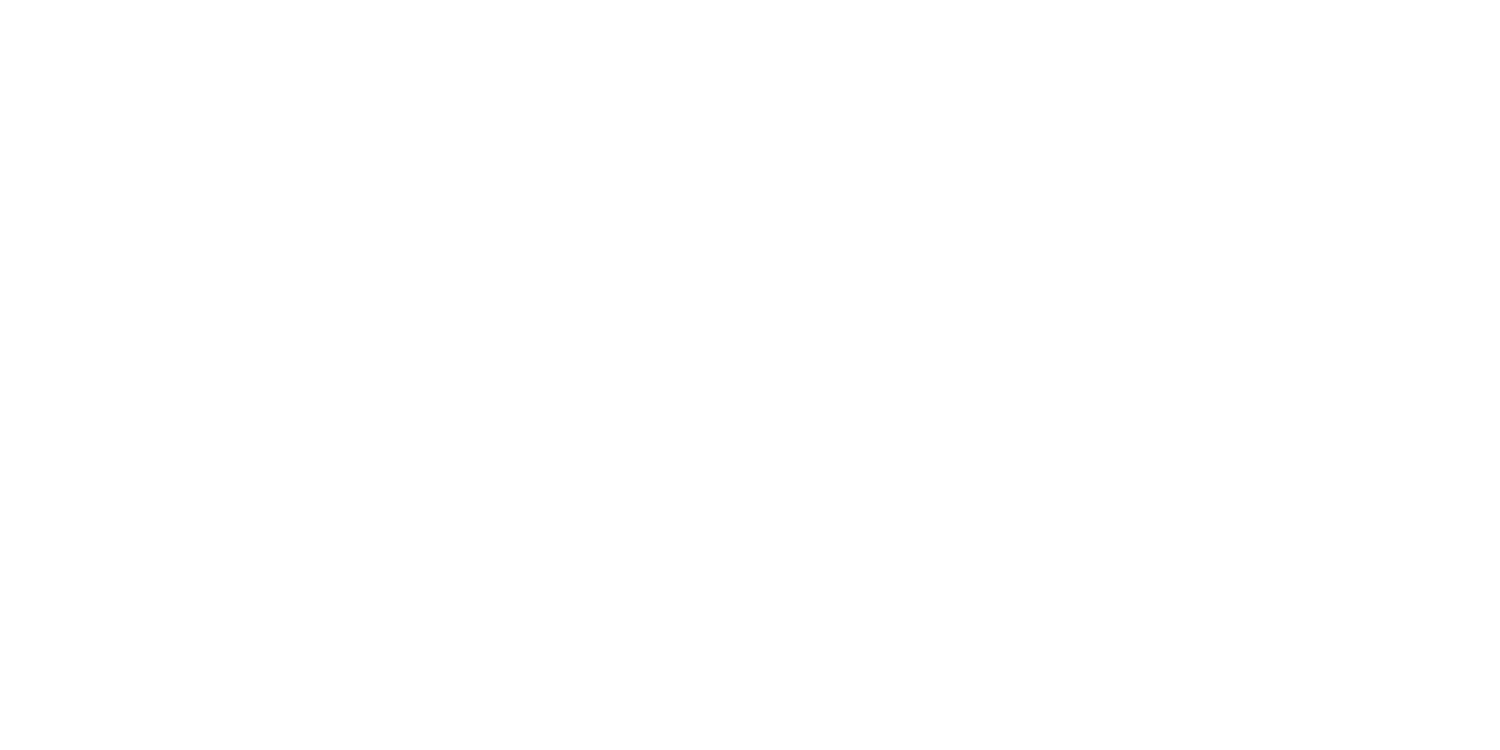

<IPython.core.display.Javascript object>


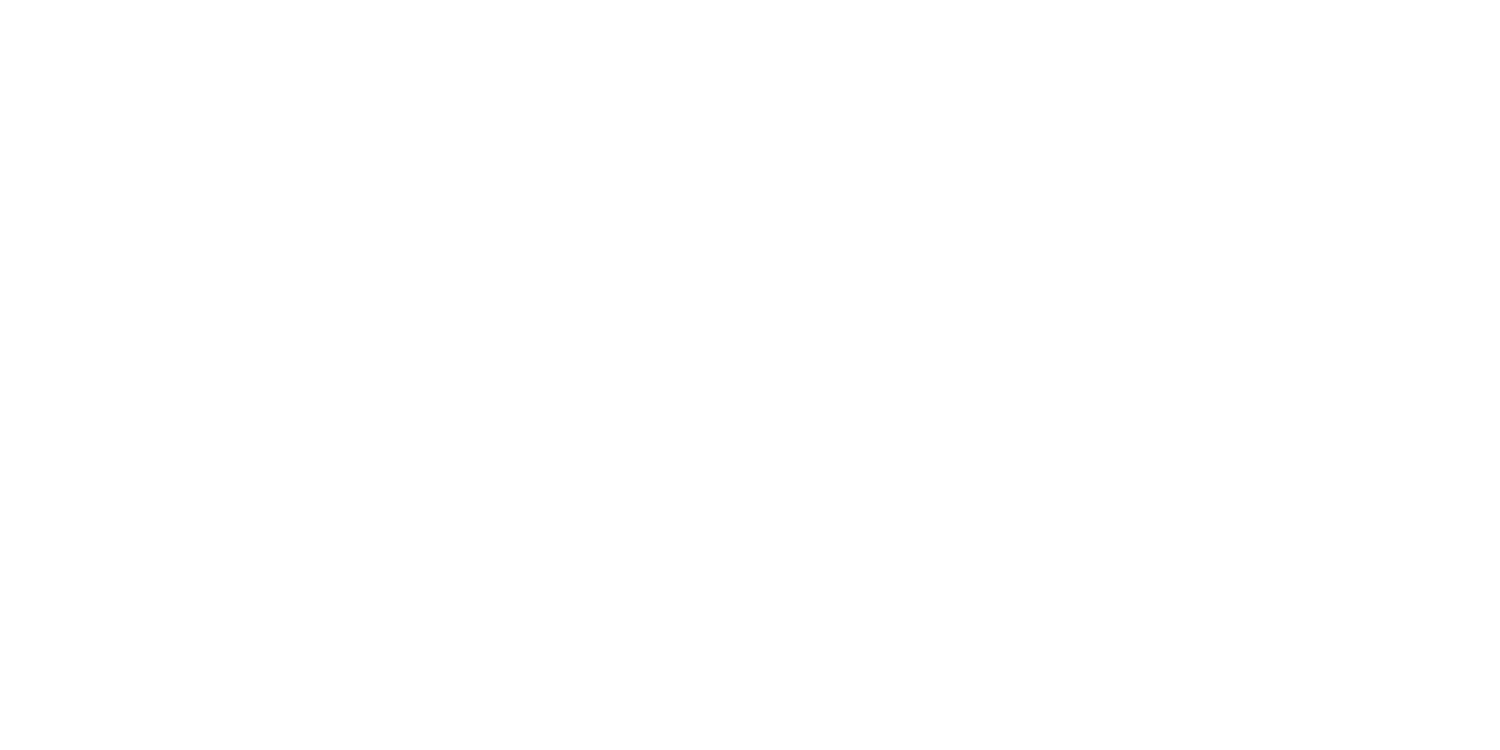

<IPython.core.display.Javascript object>


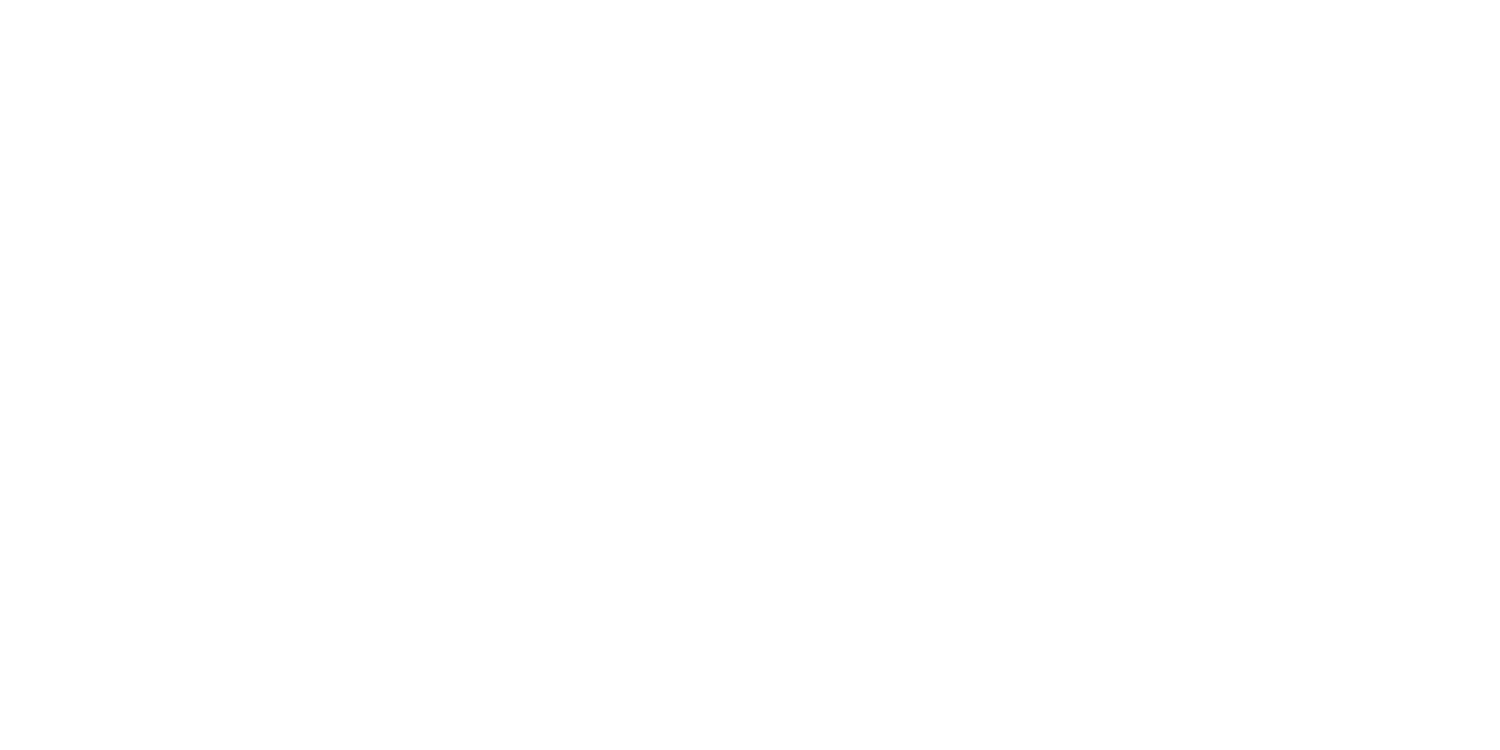

<IPython.core.display.Javascript object>


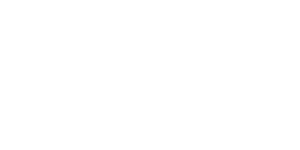

<IPython.core.display.Javascript object>


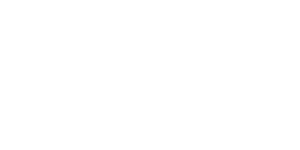

<IPython.core.display.Javascript object>


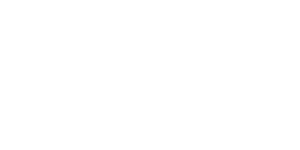

<IPython.core.display.Javascript object>


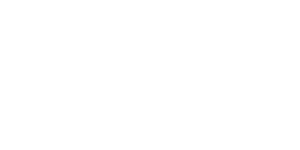

<IPython.core.display.Javascript object>


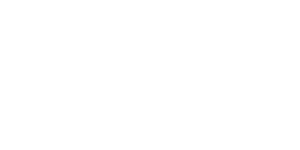

<IPython.core.display.Javascript object>


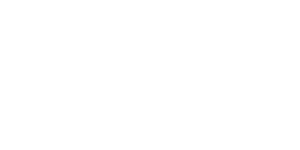

In [232]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

for V in range(50):
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(3, 3, figure=fig, width_ratios=[2, 2, 3])
    
    coeff = (Vh.T.conjugate()).T @ stack0A[t]
    sim = (coeff[:V] @ VHY[:V, :]).reshape(xdim, ydim)

    # Precompute lines to avoid recomputation
    atom_phase = unwrap_phase(np.angle(RemovePhaseGradient(complex_images_Atoms[0, 0])))
    blank_phase = unwrap_phase(np.angle(RemovePhaseGradient(blank_images[0, 0])))

    a = atom_phase.flatten()
    b = blank_phase.flatten()
    numerator = np.dot(a, b)**2
    denominator = np.dot(a, a) * np.dot(b, b)
    fraction = numerator / denominator


    cut_left = 550
    cut_right = 1000
    
    # Left Top
    ax00 = fig.add_subplot(gs[0, 0])
    ax00.plot(atom_phase[50], c='k')
    ax00.plot(sim[50], label='sim', c='b', alpha=0.6)
    ax00.plot(1 + atom_phase[50] - sim[50], label='residual', c='r', alpha=0.6)
    ax00.axvline(x=cut_left, ls='--', c='k', alpha=0.3)
    ax00.axvline(x=cut_right, ls='--', c='k', alpha=0.3)
    
    # Left Middle
    ax10 = fig.add_subplot(gs[1, 0])
    ax10.plot(np.linspace(cut_left, cut_right, cut_right-cut_left), atom_phase[50, cut_left:cut_right], c='k')
    ax10.plot(np.linspace(cut_left, cut_right, cut_right-cut_left), sim[50, cut_left:cut_right], label='sim', c='b', alpha=0.6)
    ax10.plot(np.linspace(cut_left, cut_right, cut_right-cut_left), 1 + atom_phase[50, cut_left:cut_right] - sim[50, cut_left:cut_right], label='residual', c='r', alpha=0.6)

    # Left Bottom 
    ax20 = fig.add_subplot(gs[2, 0])
    ax20.imshow((atom_phase - sim)[:, 1000:1500], vmin=-phaserange, vmax=phaserange, aspect='auto')

    
    # Right Top
    ax01 = fig.add_subplot(gs[0, 1], sharey=ax00)
    ax01.plot(atom_phase[50], c='k')
    ax01.plot(blank_phase[50], label='blank', c='b', alpha=0.6)
    ax01.plot(1 + atom_phase[50] - blank_phase[50], label='residual', c='r', alpha=0.6)
    ax01.axvline(x=cut_left, ls='--', c='k', alpha=0.3)
    ax01.axvline(x=cut_right, ls='--', c='k', alpha=0.3)
    
    # Right Middle
    ax11 = fig.add_subplot(gs[1, 1], sharey=ax10)
    ax11.plot(np.linspace(cut_left, cut_right, cut_right-cut_left), atom_phase[50, cut_left:cut_right], c='k')
    ax11.plot(np.linspace(cut_left, cut_right, cut_right-cut_left), blank_phase[50, cut_left:cut_right], label='blank', c='b', alpha=0.6)
    ax11.plot(np.linspace(cut_left, cut_right, cut_right-cut_left), 1 + atom_phase[50, cut_left:cut_right] - blank_phase[50, cut_left:cut_right], label='residual', c='r', alpha=0.6)
    
    # Right Bottom 
    ax21 = fig.add_subplot(gs[2, 1])
    ax21.imshow((atom_phase - blank_phase)[:, 1000:1500], vmin=-phaserange, vmax=phaserange, aspect='auto')

    
    for axs in fig.axes:
        axs.set_yticks([])
        axs.set_xticks([])
    
    
    ax2 = fig.add_subplot(gs[:, 2])
    if V == 0:
        ax2.plot([0], [0], 'o-', markersize=2, alpha=0.75, label="Using 0 SVD components")
    else:
        xvals = np.arange(1, V+1)
        yvals = np.cumsum(S[0:V]**2) / np.sum(S**2)
        ax2.plot(np.insert(xvals, 0, 0), np.insert(yvals, 0, 0), 'o-', markersize=2, alpha=0.75, label=f"Using {V} SVD components")

    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")

    ax2.axhline(y=fraction, ls='--', c='orange', label='Using Full Flat')
#     ax2.set_yscale('log')
    ax2.set_xlabel("SVD component index")
    ax2.set_ylabel("Fraction of total variance explained")
    ax2.legend(loc='lower right', fontsize=8)
    
    plt.tight_layout()

    plt.subplots_adjust(left=0.02, right=0.90, wspace=0.15, top=0.9)

    plt.suptitle(f"# of SVD = {V}")
    plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/PCA_Analysis/images/PCA_in_action/{str(V).zfill(4)}.png")
    plt.close()


<IPython.core.display.Javascript object>


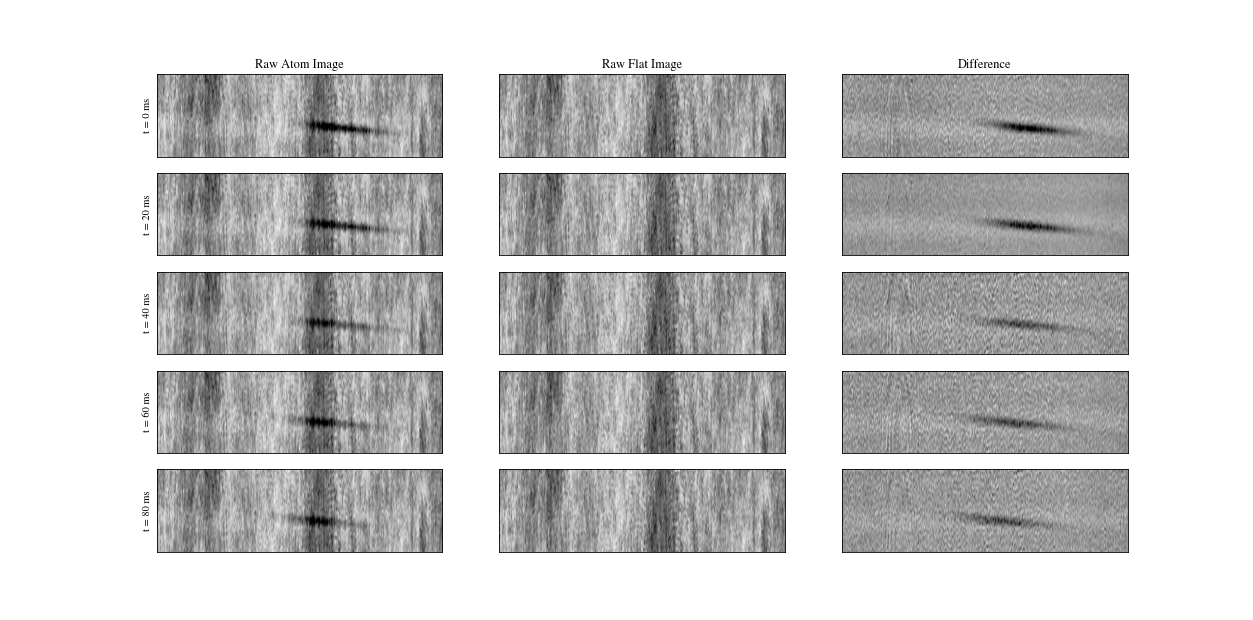

<IPython.core.display.Javascript object>


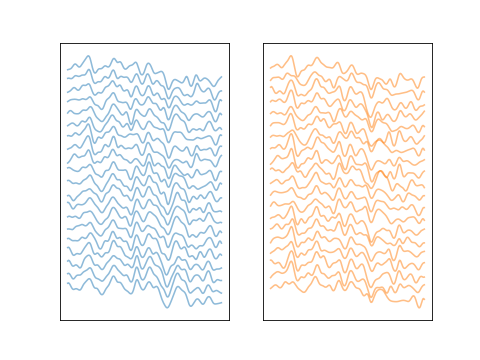

In [203]:
### VS FLAT
fig, ax = plt.subplots(5, 3)

for i in range(5):
    ax[i][0].imshow(unwrap_phase(np.angle(RemovePhaseGradient(complex_images_Atoms[i*10, 0]))), vmin=-phaserange, vmax=phaserange, aspect='auto', cmap='Greys')
    ax[i][1].imshow(unwrap_phase(np.angle(RemovePhaseGradient(blank_images[i*10, 0]))), vmin=-phaserange, vmax=phaserange, aspect='auto', cmap='Greys')
    ax[i][2].imshow(unwrap_phase(np.angle(RemovePhaseGradient(complex_images_Atoms[i*10, 0]))) - unwrap_phase(np.angle(RemovePhaseGradient(blank_images[i*10, 0]))), vmin=-phaserange, vmax=phaserange, aspect='auto', cmap='Greys')
    ax[i][0].set_ylabel(f"t = {i*2*10} ms")
    
ax[0][0].set_title("Raw Atom Image")
ax[0][1].set_title("Raw Flat Image")
ax[0][2].set_title("Difference")
    
for axa in fig.axes:
    axa.set_yticks([])
    axa.set_xticks([])
plt.show()


fig, ax = plt.subplots(1, 2)

for i in range(20):
    ax[0].plot(unwrap_phase(np.angle(RemovePhaseGradient(complex_images_Atoms[i, 0])))[20, 400:600]+i*0.4, alpha=0.5, c='C0')
    ax[1].plot(unwrap_phase(np.angle(RemovePhaseGradient(blank_images[i, 0])))[20, 400:600]+i*0.4, alpha=0.5, c='C1')

for axa in fig.axes:
    axa.set_yticks([])
    axa.set_xticks([])
plt.show()

<IPython.core.display.Javascript object>


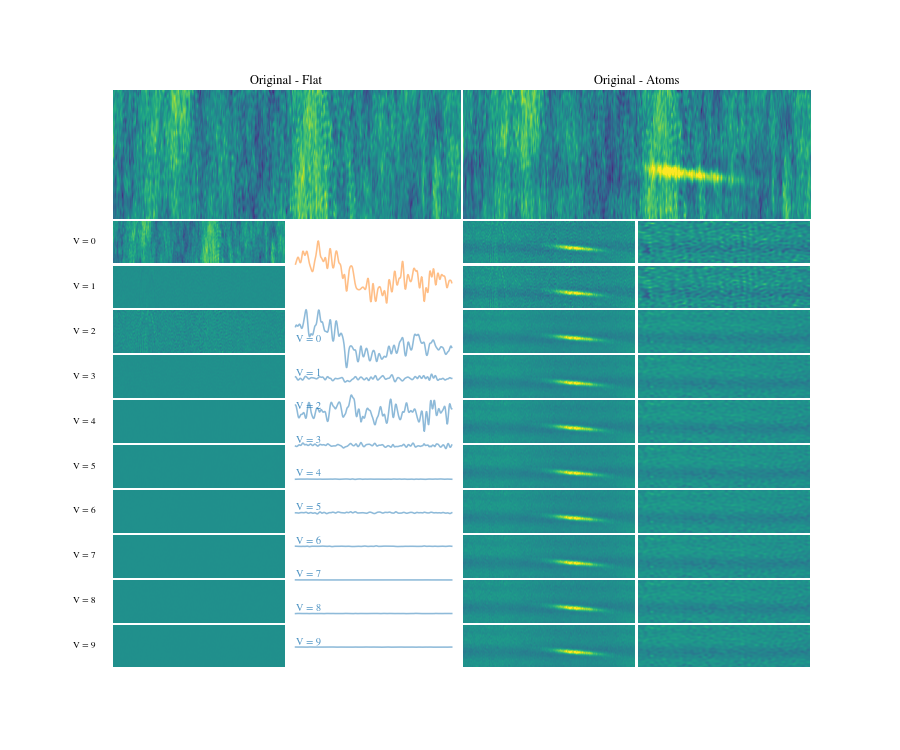

In [231]:
t = 0
phaserange = 1.0
tot = gradient_removeds_Atoms[t, 0].copy()

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(11, 4, figure=fig, hspace=0.04, wspace=0.02, height_ratios=[3, 1, 1, 1, 1, 1, 1, 1, 1,1, 1])

ax5 = fig.add_subplot(gs[1:, 1])

ax_original_flat = fig.add_subplot(gs[0, 0:2])
ax_original_flat.imshow(unwrap_phase(np.angle(RemovePhaseGradient(blank_images[t, 0]))), vmin=-phaserange, vmax=phaserange, aspect='auto')
ax_original_flat.axis('off')
ax_original_flat.set_title("Original - Flat")

ax_original_atom = fig.add_subplot(gs[0, 2:4])
ax_original_atom.imshow(gradient_removeds_Atoms[t, 0], vmin=-phaserange, vmax=phaserange, aspect='auto')
ax_original_atom.axis('off')
ax_original_atom.set_title("Original - Atoms")


ax5.plot(unwrap_phase(np.angle(RemovePhaseGradient(blank_images[t, 0])))[20, 400:800], c='C1', alpha=0.5)

for V in range(10):
    coeff_V = np.dot(Vh[V].conj(), stack0A[t])
    component = coeff_V * VHY[V]
    sim = component.reshape(xdim, ydim)

    ax0 = fig.add_subplot(gs[V+1, 0])
    ax0.imshow(sim, vmin=-phaserange, vmax=phaserange, aspect='auto')
    ax0.axis('off')
    ax0.text(-0.1, 0.5, f"V = {V}", transform=ax0.transAxes, va='center', ha='right', rotation=0, fontsize=9)

    tot -= sim
    ax3 = fig.add_subplot(gs[V+1, 2])
    ax3.imshow(tot, vmin=-phaserange, vmax=phaserange, aspect='auto')
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[V+1, 3])
    ax4.imshow(tot[:, 550:850], vmin=-phaserange, vmax=phaserange, aspect='auto')
    ax4.axis('off')
    
    ax5.plot(sim[20, 400:800]-(V+2)*0.6, c='C0', alpha=0.5)
    ax5.text(0, -(V+2)*0.6+0.05, f"V = {V}", c='C0', alpha=0.8)
    ax5.axis('off')
    
    
plt.tight_layout()
plt.show()
